# Declaration of Originality

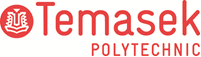

**TEMASEK POLYTECHNIC**
<br>**SCHOOL OF INFORMATICS & IT**
<br>**DIPLOMA IN INFORMATION TECHNOLOGY**
<br>**MACHINE LEARNING FOR DEVELOPERS (CAI2C08)**
<br>**AY2025/2026 OCTOBER SEMESTER**

**PROJECT PROGRAM CODES**
* Student Name (Matric Number)  : Ho Zheng Xian (2405203G)
* Tutorial Group                :  TC04
* Tutor						    :  Emile SABASTIAN
* Submission Date               : 11/2/2026


**Declaration of Originality**
* I am the originator of this work and I have appropriately acknowledged all other original sources used as my references for this work.
* I understand that Plagiarism is the act of taking and using the whole or any part of another person’s work, including work generated by AI, and presenting it as my own.
* I understand that Plagiarism is an academic offence and if I am found to have committed or abetted the offence of plagiarism in relation to this submitted work, disciplinary action will be enforced.

# Libraries

In [172]:
## Import libraries
import pandas as pd
import numpy as np


1. Business Understanding

Goal: Build a machine learning model that predicts a driver’s race finishing position (positionOrder) for modern Formula 1 seasons (focused on 2022–2024), using only pre-race / race-context information (e.g., grid position, qualifying summary, circuit attributes, and recent form features), so that we can forecast expected finishing order and run “what-if” scenarios (e.g., “If this driver started P5 instead of P12, how might their predicted finish change?”).

Why this matters (business value):

Turns historical race + qualifying data into actionable predictions for analysis and scenario testing.

Provides an interpretable benchmark for how much starting grid + recent performance influences expected results.

What the model outputs:

A predicted finishing rank (lower is better), plus ranking quality metrics (e.g., MAE, RMSE, within ±k positions, Spearman rank correlation).

How success is measured (in your notebook):

Primary: MAE on the test set (average absolute error in “positions”).

Secondary: Within±1/±3/±5, and Spearman (ranking agreement).

Compared against a simple baseline like using grid as the prediction.

# 2. Data Understanding

## 2.1 Load dataset

In [173]:
import numpy as np
import pandas as pd

# -----------------------------
# Load CSVs (Ergast uses "\N" for missing)
# Best practice: tell read_csv to treat "\N" as NaN
# In Python string literals, "\N" must be written as "\\N"
# -----------------------------
NA_MARKERS = ["\\N"]

results = pd.read_csv("archive/results.csv", na_values=NA_MARKERS)
races = pd.read_csv("archive/races.csv", na_values=NA_MARKERS)
drivers = pd.read_csv("archive/drivers.csv", na_values=NA_MARKERS)
constructors = pd.read_csv("archive/constructors.csv", na_values=NA_MARKERS)
circuits = pd.read_csv("archive/circuits.csv", na_values=NA_MARKERS)
qualifying = pd.read_csv("archive/qualifying.csv", na_values=NA_MARKERS)
status = pd.read_csv("archive/status.csv", na_values=NA_MARKERS)

# -----------------------------
# Keep only needed columns
# IMPORTANT: include statusId so we can filter DNFs later
# -----------------------------
results = results[["raceId","driverId","constructorId","grid","positionOrder","points","statusId"]]
races = races[["raceId","year","round","circuitId","name","date"]]
drivers = drivers[["driverId","dob","nationality"]]
constructors = constructors[["constructorId","nationality"]]
qualifying = qualifying[["raceId","driverId","constructorId","position","q1","q2","q3"]]
circuits = circuits[["circuitId","country","alt","lat","lng"]]
status = status[["statusId","status"]]

# -----------------------------
# Merge into one dataset (df)
# -----------------------------
df = (
    results.merge(races, on="raceId", how="left")
           .merge(drivers, on="driverId", how="left")
           .merge(constructors, on="constructorId", how="left", suffixes=("_driver", "_constructor"))
           .merge(qualifying, on=["raceId","driverId","constructorId"], how="left")
           .merge(circuits, on="circuitId", how="left")
           .merge(status, on="statusId", how="left")
)

# -----------------------------
# Finish flags
# -----------------------------
# Your strict rule: ONLY "Finished"
df["is_finished_only"] = (df["status"] == "Finished")



# Quick sanity check

print("Finished-only:", int(df["is_finished_only"].sum()), "/", len(df))

print("df shape:", df.shape)


Finished-only: 7674 / 26759
df shape: (26759, 25)


This block loads multiple CSV files from the Ergast F1 dataset using pandas.read_csv(). A key detail is that Ergast represents missing values using the string \N, which is not automatically treated as missing by pandas. If we don’t convert \N to NaN, those fields remain as literal strings and can break numeric conversions (e.g., altitude, qualifying times), distort summary statistics, and cause model preprocessing to behave incorrectly.

## 2.2 Summary Statistics

In [174]:
## Understand the type of variable for each column
df.shape


(26759, 25)

### What this cell is for
This cell checks the **shape of the merged dataset (`df`)** to confirm how many rows (driver–race entries) and columns (features) we currently have.

### Why it matters
Before doing EDA or modelling, we need a quick validation that the merge step did not unexpectedly drop rows or create duplicates. The shape gives an immediate sanity check that the dataset is in the expected scale.

### Notes
A large jump in row count often means a merge key mismatch or unintended many-to-many join. A sudden drop can indicate filtering or missing join keys.


In [175]:
## Statistical summary (mean, max, min)
df.describe(include='all')

,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,round,circuitId,...,position,q1,q2,q3,country,alt,lat,lng,status,is_finished_only
count,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,26759.000000,...,10484.000000,10328,5847,3629,26759,26759.000000,26759.000000,26759.000000,26759,26759
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,9136,5473,3470,35,NaN,NaN,NaN,137,2
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,1:20.888,1:33.416,1:35.766,Italy,NaN,NaN,NaN,Finished,False
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,4,3,3,2647,NaN,NaN,NaN,7674,19085
mean,551.687283,278.673530,50.180537,11.134796,12.794051,1.987632,17.224971,1991.394372,8.511192,23.820808,...,11.188668,NaN,NaN,NaN,NaN,276.847416,33.949556,5.724416,NaN,NaN
std,313.265036,282.703039,61.551498,7.202860,7.665951,4.351209,26.026104,19.952885,5.070231,19.112002,...,6.259034,NaN,NaN,NaN,NaN,409.086550,25.246080,57.632776,NaN,NaN
min,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1950.000000,1.000000,1.000000,...,1.000000,NaN,NaN,NaN,NaN,-7.000000,-37.849700,-118.189000,NaN,NaN
25%,300.000000,57.000000,6.000000,5.000000,6.000000,0.000000,1.000000,1977.000000,4.000000,9.000000,...,6.000000,NaN,NaN,NaN,NaN,18.000000,34.843100,-1.016940,NaN,NaN
50%,531.000000,172.000000,25.000000,11.000000,12.000000,0.000000,10.000000,1991.000000,8.000000,18.000000,...,11.000000,NaN,NaN,NaN,NaN,153.000000,43.734700,6.947500,NaN,NaN
75%,811.000000,399.500000,63.000000,17.000000,18.000000,2.000000,14.000000,2009.000000,12.000000,34.000000,...,16.000000,NaN,NaN,NaN,NaN,401.000000,49.254200,14.764700,NaN,NaN


### What this cell is for
This cell generates a **statistical overview** of every column (numeric + categorical), including common measures like count, unique, mean, min/max, etc.

### Why it matters
It helps detect:
- unexpected ranges (e.g., grid < 1)
- suspicious constant columns
- very high cardinality categorical columns (IDs)
- missing-value patterns via lower counts

### Notes
Using `include="all"` is useful in mixed datasets like F1 because we have both numeric and categorical features.


In [176]:

df[["q1","q2","q3"]].isna().sum()

q1    16431
q2    20912
q3    23130
dtype: int64

### What this cell is for
This cell counts missing values specifically for **qualifying session time columns (`q1`, `q2`, `q3`)**.

### Why it matters (domain-aware)
In F1, missing `q2`/`q3` is often **structural** (drivers did not progress to later sessions), not “bad data”. This check confirms that the pattern exists and helps decide the correct handling strategy (e.g., stage indicators like “reached Q2/Q3”, best available time, etc.).

### Notes
We should avoid treating these NaNs as random missingness; they carry meaningful information about qualifying performance/outcome.


In [177]:
## Check for missing values
df.isna().sum()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   raceId                   26759 non-null  int64  
 1   driverId                 26759 non-null  int64  
 2   constructorId            26759 non-null  int64  
 3   grid                     26759 non-null  int64  
 4   positionOrder            26759 non-null  int64  
 5   points                   26759 non-null  float64
 6   statusId                 26759 non-null  int64  
 7   year                     26759 non-null  int64  
 8   round                    26759 non-null  int64  
 9   circuitId                26759 non-null  int64  
 10  name                     26759 non-null  object 
 11  date                     26759 non-null  object 
 12  dob                      26759 non-null  object 
 13  nationality_driver       26759 non-null  object 
 14  nationality_constructo

### What this cell is for
This cell provides:
- the **count of missing values per column**
- the **data types** of each column (`df.info()`)

### Why it matters
This is used to justify preprocessing decisions:
- which columns need imputation
- which columns need type conversion
- which columns are safe to model as numeric vs categorical

### Notes
`df.info()` is especially important after merges because it reveals columns that accidentally became `object` type due to mixed values.


In [178]:
# 1) Convert date columns to datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df["dob"] = pd.to_datetime(df["dob"], errors="coerce")

# 2) Driver age at race (years)
df["driver_age"] = (df["date"] - df["dob"]).dt.days / 365.25

# 3) Convert qualifying position to numeric
df["quali_position"] = pd.to_numeric(df["position"], errors="coerce")

# 4) Convert q1/q2/q3 strings like '1:26.572' into seconds
def time_to_seconds(x):
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() == "nan" or s in ["\\N", r"\N"]:

        return np.nan
    parts = s.split(":")
    try:
        if len(parts) == 2:  # M:SS.mmm
            return int(parts[0]) * 60 + float(parts[1])
        elif len(parts) == 3:  # H:MM:SS.mmm (rare)
            return int(parts[0]) * 3600 + int(parts[1]) * 60 + float(parts[2])
        else:
            return float(s)
    except:
        return np.nan

df["q1_sec"] = df["q1"].apply(time_to_seconds)
df["q2_sec"] = df["q2"].apply(time_to_seconds)
df["q3_sec"] = df["q3"].apply(time_to_seconds)

# 5) Best available qualifying time + flag
df["quali_best_sec"] = df[["q1_sec", "q2_sec", "q3_sec"]].min(axis=1)
df["has_quali"] = (~df["quali_best_sec"].isna()).astype(int)

# Quick check
df[["driver_age", "quali_position", "quali_best_sec", "has_quali"]].isna().sum()

driver_age            0
quali_position    16275
quali_best_sec    16431
has_quali             0
dtype: int64

### What this cell is for
This cell performs important preprocessing and feature creation:
- converts `date` and `dob` into datetime
- computes **driver age at race**
- converts qualifying position to numeric
- converts qualifying times (`q1/q2/q3`) from `"m:ss.xxx"` into seconds
- creates **best available qualifying time** and a **has qualifying** flag

### Why it matters
These transformations convert raw text/date fields into **model-usable numeric features** and create qualifying signals that are more consistent than using raw `q1/q2/q3` strings.

### Notes
Using “best available” qualifying time helps handle structural missingness (not all drivers have `q2/q3`) while still keeping a performance indicator.


In [179]:
## Describe data distribution


print("Total columns:", len(df.columns))
print(df.columns.tolist())


Total columns: 32
['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'points', 'statusId', 'year', 'round', 'circuitId', 'name', 'date', 'dob', 'nationality_driver', 'nationality_constructor', 'position', 'q1', 'q2', 'q3', 'country', 'alt', 'lat', 'lng', 'status', 'is_finished_only', 'driver_age', 'quali_position', 'q1_sec', 'q2_sec', 'q3_sec', 'quali_best_sec', 'has_quali']


### What this cell is for
This prints the total number of columns and the full column list.

### Why it matters
It ensures we know exactly what features exist after merging and feature engineering, which helps prevent:
- missing-column bugs later
- accidental use of leaky fields
- confusion over naming/suffixes after merges

### Notes
This is a lightweight checkpoint that supports reproducibility and debugging.


Train Model BEFORE Feature Engineering (Later will comapre before vs after)

In [180]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ==========================================================
# BEFORE FEATURE ENGINEERING (BASELINE) — FAIR COMPARISON CELL
# Put this BEFORE your Feature Engineering cell.
#
# Goal: same split rule as AFTER-FE cell:
#   df_model = df[df["year"] >= 2006]
#   cutoff = df_model["date"].quantile(0.8)
#   train_idx/test_idx by date
#
# IMPORTANT: NO finish/DNF filter (metrics on ALL test rows)
# ==========================================================

# ----------------------------
# 0) Build df_model EXACTLY like your AFTER-FE training cell
# ----------------------------
required_cols = ["date", "year", "round", "positionOrder", "grid", "driverId", "constructorId", "circuitId", "country"]
missing_req = [c for c in required_cols if c not in df.columns]
if missing_req:
    raise ValueError(f"df is missing required columns: {missing_req}")

df_model_base = df[df["year"] >= 2006].copy()
df_model_base["date"] = pd.to_datetime(df_model_base["date"], errors="coerce")
df_model_base = df_model_base.dropna(subset=["date"]).copy()

# ----------------------------
# 1) BEFORE-FE feature set (no engineered history/team features)
#    Keep only features that exist BEFORE your FE cell.
# ----------------------------
base_feature_cols = [
    "year","round","circuitId","alt","lat","lng",
    "grid","has_quali","quali_position","quali_best_sec",
    "driver_age",
    "driverId","constructorId","country"
]

missing_base = [c for c in base_feature_cols if c not in df_model_base.columns]
if missing_base:
    raise ValueError(
        "Missing base features in df_model_base. "
        "Make sure these columns exist BEFORE FE:\n"
        f"{missing_base}"
    )

target_col = "positionOrder"

# ----------------------------
# 2) Time-based split (SAME logic as AFTER-FE cell)
# ----------------------------
cutoff = df_model_base["date"].quantile(0.8)
train_idx = df_model_base["date"] <= cutoff
test_idx  = df_model_base["date"] > cutoff

print("Train rows:", int(train_idx.sum()), "| Test rows:", int(test_idx.sum()))
print("Cutoff date:", cutoff.date())

# ----------------------------
# 3) Build X/y (one-hot, same drop_first=True)
# ----------------------------
X_raw = df_model_base[base_feature_cols].copy()
y = df_model_base[target_col].astype(float).copy()

X = pd.get_dummies(
    X_raw,
    columns=["driverId","constructorId","circuitId","country"],
    drop_first=True
)

# Fill remaining NaNs in numeric columns
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median())

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

# Save columns for later alignment (optional)
base_X_columns = X.columns

# ----------------------------
# 4) Train baseline model
# ----------------------------
hgb_before_fe = HistGradientBoostingRegressor(loss="absolute_error", random_state=2025)
hgb_before_fe.fit(X_train, y_train)
pred_test = hgb_before_fe.predict(X_test)

# ----------------------------
# 5) Metrics on ALL test rows (NO filter)
# ----------------------------
y_true = y_test.values.astype(float)
pred = pred_test.astype(float)

abs_err = np.abs(y_true - pred)

mae = mean_absolute_error(y_true, pred)
rmse = np.sqrt(mean_squared_error(y_true, pred))

within1 = (abs_err <= 1).mean()
within3 = (abs_err <= 3).mean()
within5 = (abs_err <= 5).mean()

pred_round = np.clip(np.rint(pred), 1, 40)
exact = (np.abs(y_true - pred_round) == 0).mean()

spearman = pd.Series(y_true).corr(pd.Series(pred), method="spearman")

report = pd.DataFrame([{
    "model": "HistGradientBoosting(abs_error) — BEFORE FE",
    "rows_used": len(y_true),
    "MAE": mae,
    "RMSE": rmse,
    "Within±1": within1,
    "Within±3": within3,
    "Within±5": within5,
    "Exact(rounded)%": exact,
    "Spearman": spearman
}]).set_index("model")

print("\n=== BEFORE FEATURE ENGINEERING (BASELINE) METRICS ===")
display(report)

# ----------------------------
# 6) Save split info so you can VERIFY it matches AFTER-FE
# ----------------------------
before_fe_cutoff = cutoff
before_fe_train_rows = int(train_idx.sum())
before_fe_test_rows = int(test_idx.sum())
print("\nSaved: hgb_before_fe, before_fe_cutoff, before_fe_train_rows, before_fe_test_rows, base_feature_cols, base_X_columns")


Train rows: 6335 | Test rows: 1579
Cutoff date: 2021-08-01

=== BEFORE FEATURE ENGINEERING (BASELINE) METRICS ===


,rows_used,MAE,RMSE,Within±1,Within±3,Within±5,Exact(rounded)%,Spearman
model,,,,,,,,
HistGradientBoosting(abs_error) — BEFORE FE,1579,3.04252,4.332581,0.260291,0.632679,0.834072,0.139962,0.676862



Saved: hgb_before_fe, before_fe_cutoff, before_fe_train_rows, before_fe_test_rows, base_feature_cols, base_X_columns


As you can see using HistGradientBoosting model my MAE which means average position that is off is about 3 positions away from actual and this is inclduing unpredictable scenarios like the driver not finishing a race due to whatever the reason like a crash which is unfair to punish the accuracy for so later it will be seen the filtered MAE the actual metric how well the model is doing.

## Iterative model development


In [181]:
################################################################
#### 📈 FEATURE ENGINEERING (PAST PERFORMANCE, NO LEAKAGE) 📈
################################################################

import numpy as np
import pandas as pd

# Sort chronologically (important for "last 5 races")
df = df.sort_values(["date", "round", "raceId", "driverId"]).reset_index(drop=True)

# ------------------------------------------------------------
# Experience: races completed before this one
# ------------------------------------------------------------
df["driver_races_before"] = df.groupby("driverId").cumcount()
df["constructor_races_before"] = df.groupby("constructorId").cumcount()

# ------------------------------------------------------------
# Driver last finish + rolling averages (shift(1) avoids leakage)
# ------------------------------------------------------------
df["driver_last_finish"] = df.groupby("driverId")["positionOrder"].shift(1)

df["driver_avg_finish_last5"] = df.groupby("driverId")["positionOrder"].transform(
    lambda s: s.shift(1).rolling(5, min_periods=1).mean()
)

df["driver_avg_points_last5"] = df.groupby("driverId")["points"].transform(
    lambda s: s.shift(1).rolling(5, min_periods=1).mean()
)

# ------------------------------------------------------------
# Constructor rolling averages (shifted)
# ------------------------------------------------------------
df["constructor_avg_finish_last5"] = df.groupby("constructorId")["positionOrder"].transform(
    lambda s: s.shift(1).rolling(5, min_periods=1).mean()
)

df["constructor_avg_points_last5"] = df.groupby("constructorId")["points"].transform(
    lambda s: s.shift(1).rolling(5, min_periods=1).mean()
)

# ------------------------------------------------------------
# Season points to date (shifted)
# ------------------------------------------------------------
df["driver_season_points_to_date"] = df.groupby(["driverId", "year"])["points"].transform(
    lambda s: s.shift(1).fillna(0).cumsum()
)

df["constructor_season_points_to_date"] = df.groupby(["constructorId", "year"])["points"].transform(
    lambda s: s.shift(1).fillna(0).cumsum()
)

# ==========================================================
# ✅ TEAM-LEVEL CAR STRENGTH FEATURES (BOTH teammates) — NO LEAKAGE
# ==========================================================

required = ["year", "round", "raceId", "constructorId", "circuitId", "driverId", "positionOrder", "points"]
missing_req = [c for c in required if c not in df.columns]
if missing_req:
    raise ValueError(f"Missing required columns for team features: {missing_req}")

team_race = (
    df.groupby(["year", "round", "raceId", "constructorId", "circuitId"], as_index=False)
      .agg(
          team_finish_mean=("positionOrder", "mean"),
          team_points_mean=("points", "mean"),
          team_driver_count=("driverId", "nunique"),
      )
      .sort_values(["year", "round", "raceId", "constructorId"])
      .reset_index(drop=True)
)

team_race["team_avg_finish_last5_teammates"] = (
    team_race.groupby(["year", "constructorId"])["team_finish_mean"]
             .transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
)

team_race["team_avg_points_last5_teammates"] = (
    team_race.groupby(["year", "constructorId"])["team_points_mean"]
             .transform(lambda s: s.shift(1).rolling(5, min_periods=1).mean())
)

team_track_year = (
    team_race.groupby(["constructorId", "circuitId", "year"], as_index=False)
             .agg(team_finish_same_track=("team_finish_mean", "mean"))
             .sort_values(["constructorId", "circuitId", "year"])
             .reset_index(drop=True)
)

team_track_year["team_avg_finish_last_year_same_track"] = (
    team_track_year.groupby(["constructorId", "circuitId"])["team_finish_same_track"].shift(1)
)

df = df.merge(
    team_race[[
        "year", "round", "raceId", "constructorId",
        "team_avg_finish_last5_teammates",
        "team_avg_points_last5_teammates",
    ]],
    on=["year", "round", "raceId", "constructorId"],
    how="left"
)

df = df.merge(
    team_track_year[[
        "constructorId", "circuitId", "year",
        "team_avg_finish_last_year_same_track",
    ]],
    on=["constructorId", "circuitId", "year"],
    how="left"
)

# ==========================================================
# ✅ NEW: DRIVER OUTPERFORMING CAR FEATURES (NO LEAKAGE)
# This is the key missing piece that separates Max vs Lewis in a bad car.
# ==========================================================
EPS = 1e-6

df["driver_vs_team_finish_delta_last5"] = (
    df["driver_avg_finish_last5"] - df["team_avg_finish_last5_teammates"]
)

df["driver_vs_team_finish_ratio_last5"] = (
    df["driver_avg_finish_last5"] / (df["team_avg_finish_last5_teammates"] + EPS)
)

df["driver_vs_team_points_delta_last5"] = (
    df["driver_avg_points_last5"] - df["team_avg_points_last5_teammates"]
)

df["driver_vs_team_points_ratio_last5"] = (
    df["driver_avg_points_last5"] / (df["team_avg_points_last5_teammates"] + EPS)
)

# Quick NA checks (expected early season / first time at track)
df[[
    "driver_last_finish",
    "driver_avg_finish_last5",
    "driver_avg_points_last5",
    "constructor_avg_finish_last5",
    "constructor_avg_points_last5",
    "team_avg_finish_last5_teammates",
    "team_avg_points_last5_teammates",
    "team_avg_finish_last_year_same_track",
    "driver_vs_team_finish_delta_last5",
    "driver_vs_team_finish_ratio_last5",
    "driver_vs_team_points_delta_last5",
    "driver_vs_team_points_ratio_last5",
]].isna().sum()


driver_last_finish                       861
driver_avg_finish_last5                  861
driver_avg_points_last5                  861
constructor_avg_finish_last5             211
constructor_avg_points_last5             211
team_avg_finish_last5_teammates         2416
team_avg_points_last5_teammates         2416
team_avg_finish_last_year_same_track    5459
driver_vs_team_finish_delta_last5       2850
driver_vs_team_finish_ratio_last5       2850
driver_vs_team_points_delta_last5       2850
driver_vs_team_points_ratio_last5       2850
dtype: int64

# 3. Data Preparation

## 3.1 Data Cleaning

In [182]:
################################################################
#### 🧼 HANDLE MISSING VALUES (IMPUTATION) 🧼
################################################################

import numpy as np
import pandas as pd

# 1) Rolling/history + team + outperform features
history_cols = [
    "driver_last_finish",
    "driver_avg_finish_last5",
    "driver_avg_points_last5",
    "constructor_avg_finish_last5",
    "constructor_avg_points_last5",
    "team_avg_finish_last5_teammates",
    "team_avg_points_last5_teammates",
    "team_avg_finish_last_year_same_track",
    "driver_vs_team_finish_delta_last5",
    "driver_vs_team_finish_ratio_last5",
    "driver_vs_team_points_delta_last5",
    "driver_vs_team_points_ratio_last5",
]

for c in history_cols:
    if c in df.columns:
        if pd.api.types.is_numeric_dtype(df[c]):
            med = df[c].median()
            if pd.notna(med):
                df[c] = df[c].fillna(med)
            else:
                df[c] = df[c].fillna(0)
        else:
            df[c] = df[c].fillna(0)

# 2) Qualifying
if "quali_best_sec" in df.columns:
    df["quali_best_sec"] = df["quali_best_sec"].fillna(df["quali_best_sec"].median())
if "quali_position" in df.columns:
    df["quali_position"] = df["quali_position"].fillna(df["quali_position"].median())

if "has_quali" in df.columns:
    df["has_quali"] = df["has_quali"].fillna(0).astype(int)

# 3) Driver age
if "driver_age" in df.columns:
    df["driver_age"] = df["driver_age"].fillna(df["driver_age"].median())

# 4) Circuit numeric
for c in ["alt", "lat", "lng"]:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# 5) Grid (IMPORTANT)
if "grid" in df.columns:
    df["grid"] = df["grid"].fillna(df["grid"].median())
    # prevent impossible values
    df["grid"] = df["grid"].clip(lower=1)

# 6) Country
if "country" in df.columns:
    df["country"] = df["country"].fillna("Unknown")

# Optional qualy helper seconds
for c in ["q1_sec", "q2_sec", "q3_sec"]:
    if c in df.columns:
        df[c] = df[c].fillna(df[c].median())

# Check remaining missing
df.isna().sum().sort_values(ascending=False).head(25)


q3                                      23130
q2                                      20912
q1                                      16431
position                                16275
raceId                                      0
quali_position                              0
q2_sec                                      0
q3_sec                                      0
quali_best_sec                              0
has_quali                                   0
driver_races_before                         0
constructor_races_before                    0
driver_last_finish                          0
driver_avg_finish_last5                     0
driver_avg_points_last5                     0
constructor_avg_finish_last5                0
constructor_avg_points_last5                0
driver_season_points_to_date                0
constructor_season_points_to_date           0
team_avg_finish_last5_teammates             0
team_avg_points_last5_teammates             0
team_avg_finish_last_year_same_tra

### What this cell is for
This cell applies **imputation rules** to fill missing values across engineered and core features:
- history/rolling features (median/0 depending on dtype)
- qualifying-related features (median for times/positions, 0 for flags)
- circuit numeric fields (median)
- `grid` filled + clipped to valid range (>=1)
- `country` filled with `"Unknown"`
- optional helper seconds columns (`q1_sec/q2_sec/q3_sec`) filled with median

### Why it matters
Most ML models cannot handle NaNs directly. Imputation:
- prevents training/inference errors
- keeps rows usable (reduces data loss)
- ensures inputs remain within sensible constraints (e.g., grid cannot be 0/negative)

### Notes (important for your project)
Qualifying missingness is often **structural**; your pipeline already uses `quali_best_sec` + flags to preserve meaning. The imputation strategy should be described as “domain-aware” rather than “fixing bad data”.


In [183]:
import pandas as pd

# ✅ UPDATED feature_cols (adds TEAM + OUTPERFORM features)
feature_cols = [
    "year","round","circuitId","alt","lat","lng",
    "grid","has_quali","quali_position","quali_best_sec",
    "driver_age",
    "driver_races_before","constructor_races_before",
    "driver_last_finish","driver_avg_finish_last5","driver_avg_points_last5",
    "constructor_avg_finish_last5","constructor_avg_points_last5",

    # ✅ car strength
    "team_avg_finish_last5_teammates",
    "team_avg_points_last5_teammates", 
    "team_avg_finish_last_year_same_track",

    # ✅ driver outperforming car
    "driver_vs_team_finish_delta_last5",
    "driver_vs_team_finish_ratio_last5",
    "driver_vs_team_points_delta_last5",
    "driver_vs_team_points_ratio_last5",

    "driver_season_points_to_date","constructor_season_points_to_date",
    "driverId","constructorId","country"
]

missing_cols = [c for c in feature_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f"These feature_cols are missing from df: {missing_cols}")

na_count = df[feature_cols].isna().sum()
na_pct = (na_count / len(df) * 100).round(2)

na_report = (
    pd.DataFrame({"na_count": na_count, "na_pct": na_pct})
      .sort_values(["na_count","na_pct"], ascending=False)
)

print("Top missing feature columns (count + %):")
display(na_report.head(30))

top_missing = na_report[na_report["na_count"] > 0].head(5).index.tolist()
if top_missing:
    print("\nExample rows where these top-missing features are NaN:")
    display(
        df.loc[df[top_missing].isna().any(axis=1),
               ["year","round","raceId","driverId","constructorId","circuitId"] + top_missing
        ].head(15)
    )
else:
    print("\n✅ No missing values in feature_cols.")


Top missing feature columns (count + %):


,na_count,na_pct
year,0,0.0
round,0,0.0
circuitId,0,0.0
alt,0,0.0
lat,0,0.0
lng,0,0.0
grid,0,0.0
has_quali,0,0.0
quali_position,0,0.0
quali_best_sec,0,0.0



✅ No missing values in feature_cols.


## 2.3 Data Visualization

Shape (2022–2024): (1359, 48)

Rows per year:


,rows
year,
2022,440
2023,440
2024,479



Top missing columns:


,na_count,na_pct
q3,699,51.43
q2,349,25.68
q1,13,0.96



Key columns describe():


,grid,positionOrder,points,team_avg_finish_last5_teammates,team_avg_points_last5_teammates,driver_avg_finish_last5,driver_avg_points_last5,driver_vs_team_finish_delta_last5,driver_vs_team_points_delta_last5
count,1359.000000,1359.00000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000,1359.000000
mean,9.976453,10.49301,5.097130,10.572737,4.902808,10.428722,5.127766,-0.050564,0.035774
std,5.770988,5.76476,7.245494,3.989303,5.696734,4.271695,6.048831,1.965498,2.507288
min,1.000000,1.00000,0.000000,1.500000,0.000000,1.000000,0.000000,-13.300000,-12.600000
25%,5.000000,5.50000,0.000000,7.000000,0.500000,7.200000,0.400000,-1.100000,-0.600000
50%,10.000000,10.00000,1.000000,11.700000,2.000000,11.200000,2.200000,0.000000,0.000000
75%,15.000000,15.00000,9.500000,13.700000,9.100000,13.800000,8.600000,1.100000,0.800000
max,20.000000,20.00000,26.000000,18.500000,22.000000,20.000000,25.800000,10.700000,16.200000


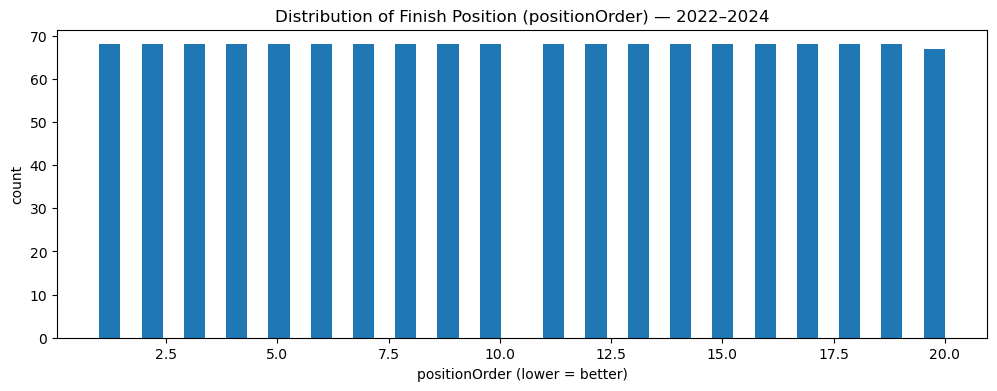

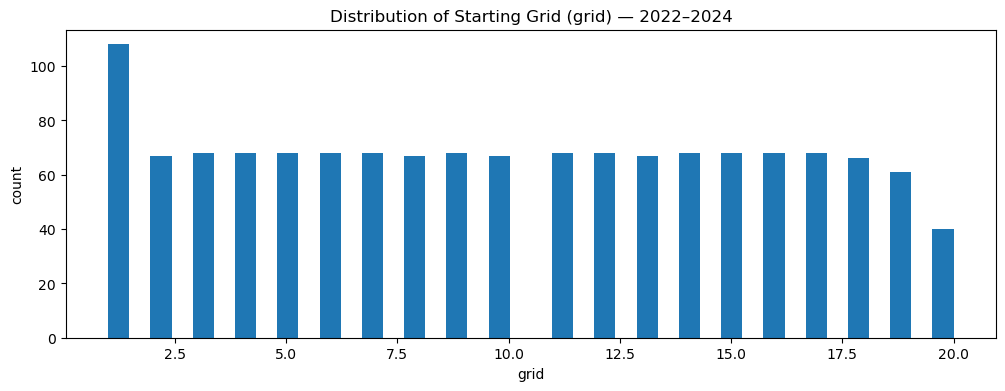

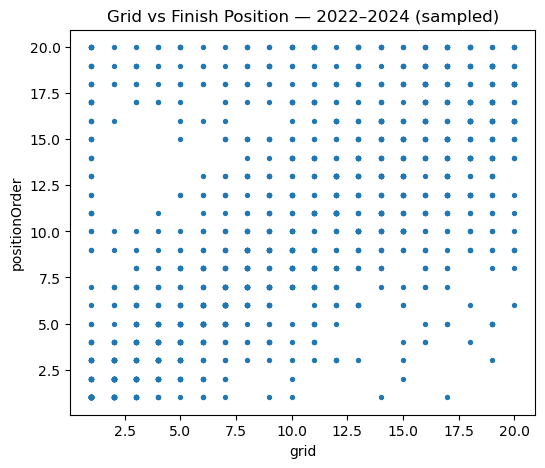

In [184]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ==========================================================
# FINAL PREPROCESSING SUMMARY (EDA) — 2022–2024 only

# ==========================================================

df_eda = df.copy()

# 1) Keep only seasons you want to showcase
df_eda = df_eda[df_eda["year"].between(2022, 2024)].copy()

# 2) Basic integrity checks
print("Shape (2022–2024):", df_eda.shape)
print("\nRows per year:")
display(df_eda["year"].value_counts().sort_index().to_frame("rows"))

# 3) Missing values summary (top 25)
na = df_eda.isna().sum().sort_values(ascending=False)
na_pct = (na / len(df_eda) * 100).round(2)
na_table = pd.DataFrame({"na_count": na, "na_pct": na_pct})
print("\nTop missing columns:")
display(na_table[na_table["na_count"] > 0].head(25))

# 4) Quick stats for key columns you care about
key_cols = [
    "grid", "positionOrder", "points",
    "team_avg_finish_last5_teammates",
    "team_avg_points_last5_teammates",
    "driver_avg_finish_last5",
    "driver_avg_points_last5",
    "driver_vs_team_finish_delta_last5",
    "driver_vs_team_points_delta_last5",
]
key_cols = [c for c in key_cols if c in df_eda.columns]

print("\nKey columns describe():")
display(df_eda[key_cols].describe(include="all"))

# 5) Distribution plots (simple + readable)
fig = plt.figure(figsize=(12, 4))
plt.hist(df_eda["positionOrder"].dropna(), bins=40)
plt.title("Distribution of Finish Position (positionOrder) — 2022–2024")
plt.xlabel("positionOrder (lower = better)")
plt.ylabel("count")
plt.show()

fig = plt.figure(figsize=(12, 4))
plt.hist(df_eda["grid"].dropna(), bins=40)
plt.title("Distribution of Starting Grid (grid) — 2022–2024")
plt.xlabel("grid")
plt.ylabel("count")
plt.show()

# 6) Relationship check: grid vs finish
sample = df_eda[["grid","positionOrder"]].dropna().sample(min(8000, len(df_eda)), random_state=2025)
plt.figure(figsize=(6, 5))
plt.scatter(sample["grid"], sample["positionOrder"], s=8)
plt.title("Grid vs Finish Position — 2022–2024 (sampled)")
plt.xlabel("grid")
plt.ylabel("positionOrder")
plt.show()


What this cell is for

This cell creates a final, presentation-ready EDA snapshot (df_eda) by taking your fully merged dataset (df) and restricting it to recent seasons (2022–2024). The purpose is to show a clean “final dataset check” right after preprocessing/feature engineering, so you can document that the data used for demonstration is realistic, consistent, and well understood.

What it does (step-by-step)

Creates a copy for EDA

df_eda = df.copy() ensures your EDA checks won’t accidentally modify the main dataset used later for training/testing.

Filters to 2022–2024

df_eda = df_eda[df_eda["year"].between(2022, 2024)] keeps only the seasons you want to showcase (recent era, consistent rules, modern drivers/teams).

Integrity checks
|
Prints the shape and number of rows per year to confirm the filter worked and the dataset size is reasonable.

Missingness summary

Builds a missing-value table (counts and %) and shows the top missing columns.

This is used to justify how you handle missing values (and whether they are “normal missingness” vs data quality issues).

Quick stats for key columns

Runs .describe() on important columns like grid, positionOrder, points, and your engineered rolling/team features to verify ranges, spread, and detect obvious anomalies (e.g., impossible grid values, weird constant columns).

Simple visual checks

Plots:

distribution of finish position (positionOrder)

distribution of starting grid (grid)

scatter of grid vs positionOrder (relationship check)

## 2.3 Data Visualization

### 2.3.1 Understanding distribution of data

### 2.3.1.1 Understanding distribution of target

In [185]:
## Understanding distribution of target
# Find correlation
df.corr(numeric_only=True)

,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,round,circuitId,...,constructor_avg_points_last5,driver_season_points_to_date,constructor_season_points_to_date,team_avg_finish_last5_teammates,team_avg_points_last5_teammates,team_avg_finish_last_year_same_track,driver_vs_team_finish_delta_last5,driver_vs_team_finish_ratio_last5,driver_vs_team_points_delta_last5,driver_vs_team_points_ratio_last5
raceId,1.000000,0.753768,0.439926,-0.035456,-0.076786,0.242543,-0.018386,0.091595,0.057888,0.262548,...,0.305032,0.274777,0.299542,-0.138381,0.305996,-0.083474,0.009194,0.005736,0.001986,0.013081
driverId,0.753768,1.000000,0.322572,0.051072,-0.015473,0.052361,-0.006415,0.064487,0.016931,0.181952,...,0.088519,0.068349,0.106495,-0.066323,0.085126,-0.021832,0.033161,0.025780,-0.042760,-0.005986
constructorId,0.439926,0.322572,1.000000,0.105731,0.080735,-0.049738,0.092891,-0.166254,-0.072824,0.136388,...,-0.060775,-0.051629,-0.040867,0.079940,-0.056817,0.073440,0.001319,0.001378,-0.003154,0.000358
grid,-0.035456,0.051072,0.105731,1.000000,0.183323,-0.384346,-0.096141,-0.020956,0.005978,-0.002452,...,-0.369128,-0.299968,-0.296121,0.300603,-0.368885,0.233787,0.054084,0.019645,-0.062296,-0.003326
positionOrder,-0.076786,-0.015473,0.080735,0.183323,1.000000,-0.576483,0.524902,-0.107401,-0.020986,-0.004430,...,-0.354823,-0.294351,-0.294169,0.502155,-0.356968,0.294056,0.044082,0.008670,-0.041042,-0.003257
points,0.242543,0.052361,-0.049738,-0.384346,-0.576483,1.000000,-0.269385,0.288615,0.095933,0.000116,...,0.679851,0.613166,0.597379,-0.411513,0.684073,-0.293406,-0.047400,-0.027456,0.091551,-0.001738
statusId,-0.018386,-0.006415,0.092891,-0.096141,0.524902,-0.269385,1.000000,-0.219814,-0.087713,0.037421,...,-0.193420,-0.168594,-0.164348,0.339489,-0.193011,0.187362,0.043748,0.026047,-0.024124,0.003386
year,0.091595,0.064487,-0.166254,-0.020956,-0.107401,0.288615,-0.219814,1.000000,0.337228,-0.176449,...,0.359884,0.355319,0.335344,-0.091685,0.352187,-0.106044,-0.032067,-0.045840,0.010355,0.012137
round,0.057888,0.016931,-0.072824,0.005978,-0.020986,0.095933,-0.087713,0.337228,1.000000,0.129265,...,0.119604,0.395088,0.403891,-0.002395,0.153295,-0.017211,-0.017889,-0.079787,0.003809,-0.105170
circuitId,0.262548,0.181952,0.136388,-0.002452,-0.004430,0.000116,0.037421,-0.176449,0.129265,1.000000,...,-0.002805,0.063636,0.074650,-0.012013,0.015533,0.000924,-0.002257,-0.010882,0.004189,-0.003003


### 2.3.1.2 Understanding distribution of features

Shape: (26759, 48)


,raceId,driverId,constructorId,grid,positionOrder,points,statusId,year,round,circuitId,...,constructor_avg_points_last5,driver_season_points_to_date,constructor_season_points_to_date,team_avg_finish_last5_teammates,team_avg_points_last5_teammates,team_avg_finish_last_year_same_track,driver_vs_team_finish_delta_last5,driver_vs_team_finish_ratio_last5,driver_vs_team_points_delta_last5,driver_vs_team_points_ratio_last5
0,833,579,51,3,12,0.0,44,1950,1,9,...,0.6,0.0,0.0,12.4,0.7,12.0,0.0,1.0,0.0,0.666666
1,833,589,105,11,18,0.0,8,1950,1,9,...,0.6,0.0,0.0,12.4,0.7,12.0,0.0,1.0,0.0,0.666666
2,833,619,151,13,6,0.0,13,1950,1,9,...,0.6,0.0,0.0,12.4,0.7,12.0,0.0,1.0,0.0,0.666666
3,833,627,154,9,5,2.0,12,1950,1,9,...,0.6,0.0,0.0,12.4,0.7,12.0,0.0,1.0,0.0,0.666666
4,833,640,105,8,17,0.0,5,1950,1,9,...,0.0,0.0,0.0,12.4,0.7,12.0,0.0,1.0,0.0,0.666666


,dtype,missing_count,missing_%,n_unique
q3,object,23130,86.44,3470
q2,object,20912,78.15,5473
q1,object,16431,61.40,9136
position,float64,16275,60.82,28
driver_vs_team_finish_ratio_last5,float64,0,0.00,12938
q1_sec,float64,0,0.00,9137
quali_best_sec,float64,0,0.00,9136
driver_age,float64,0,0.00,7620
q2_sec,float64,0,0.00,5473
driver_vs_team_points_ratio_last5,float64,0,0.00,5190


Numeric cols: 37
Categorical/other cols: 11


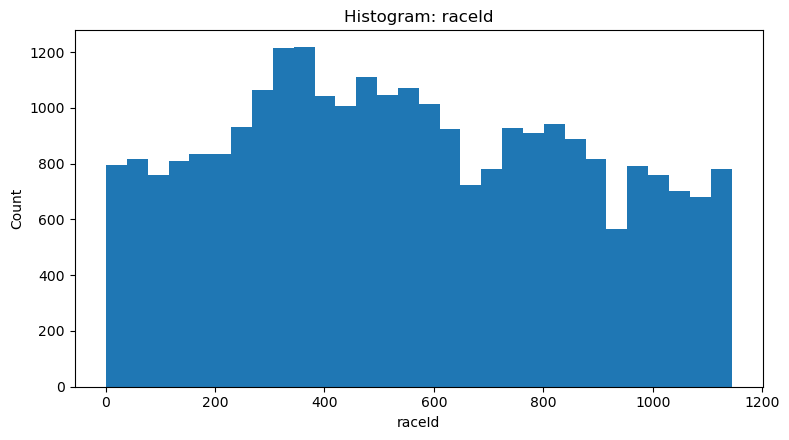

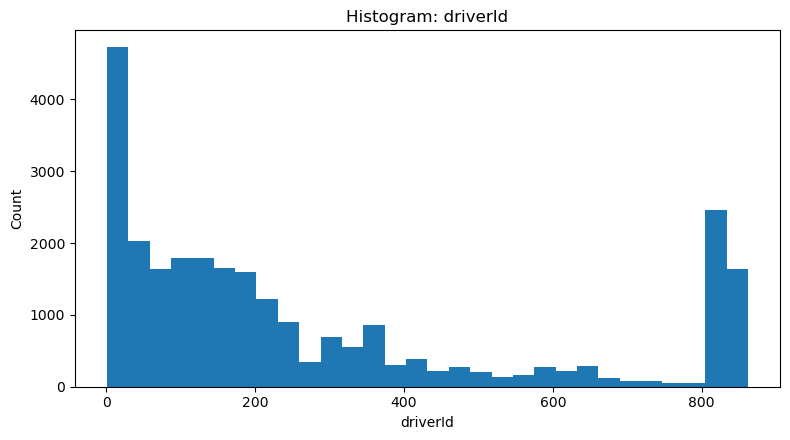

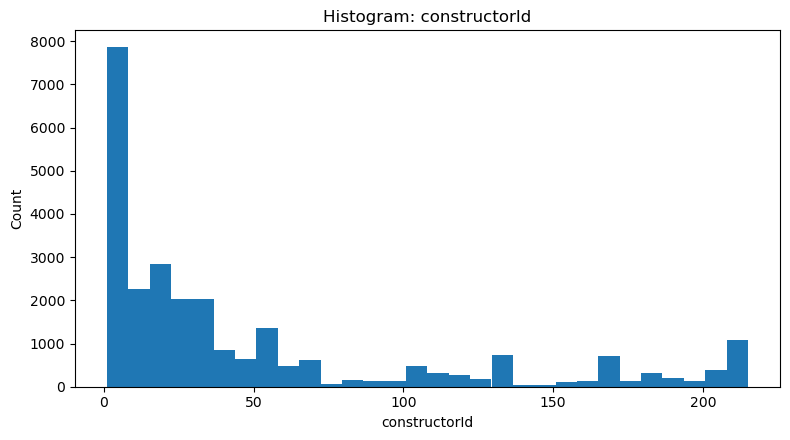

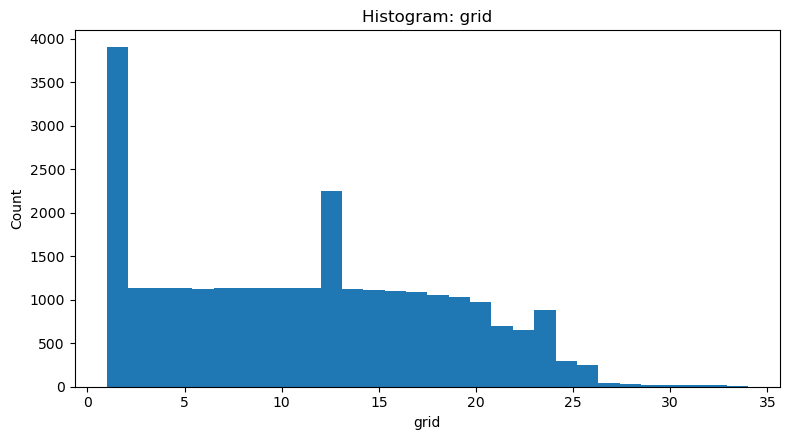

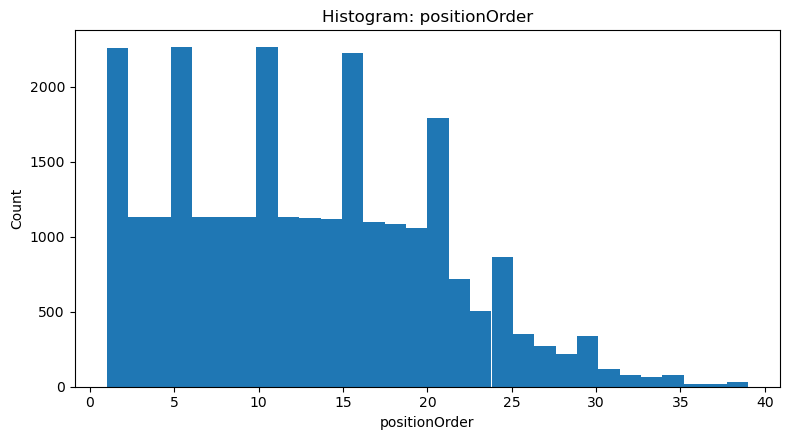

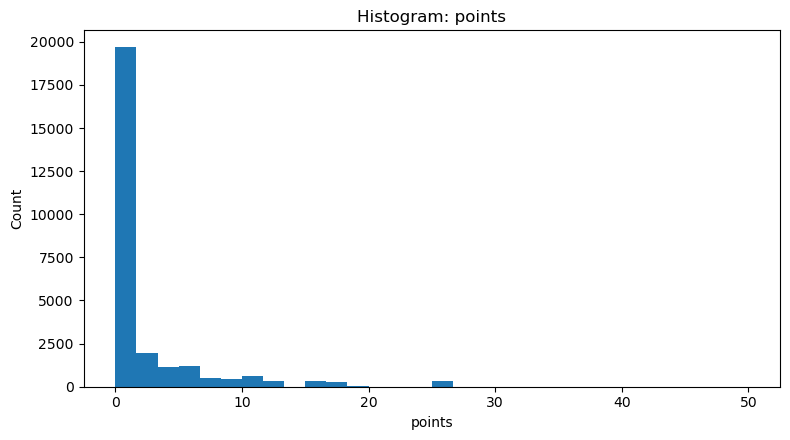

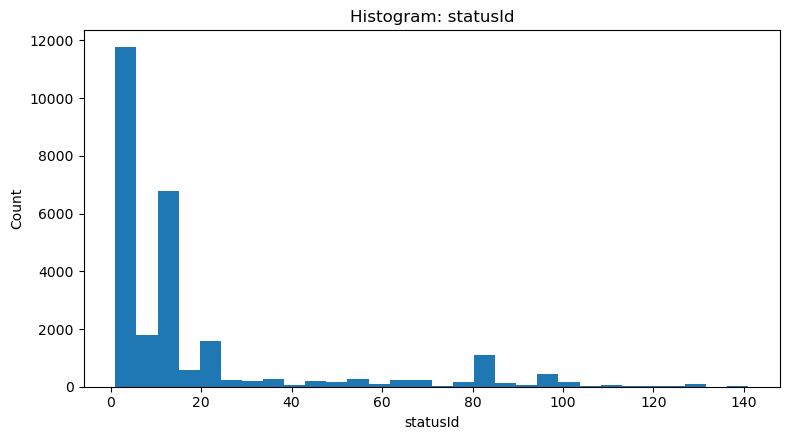

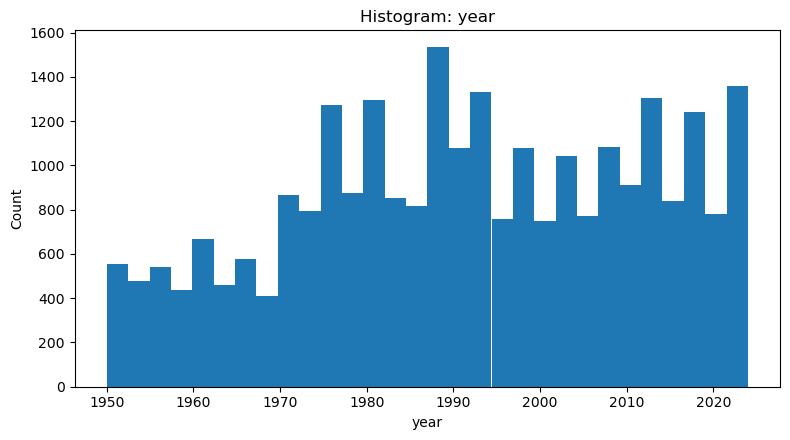

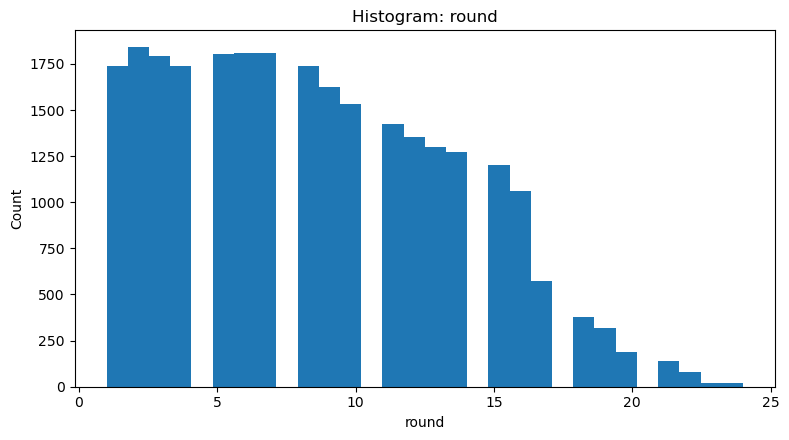

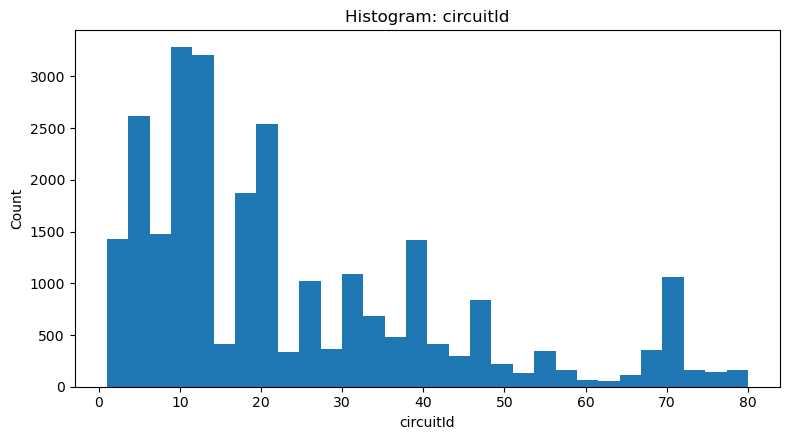

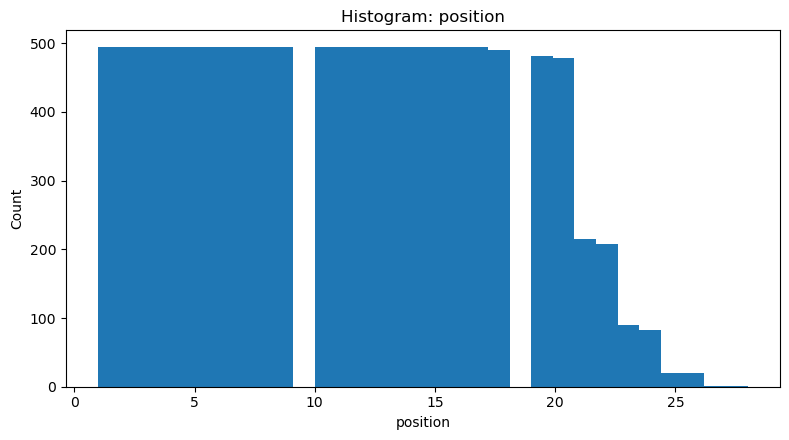

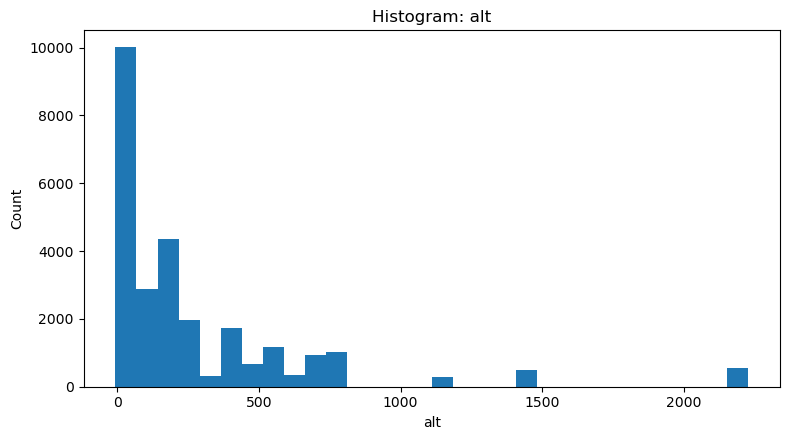

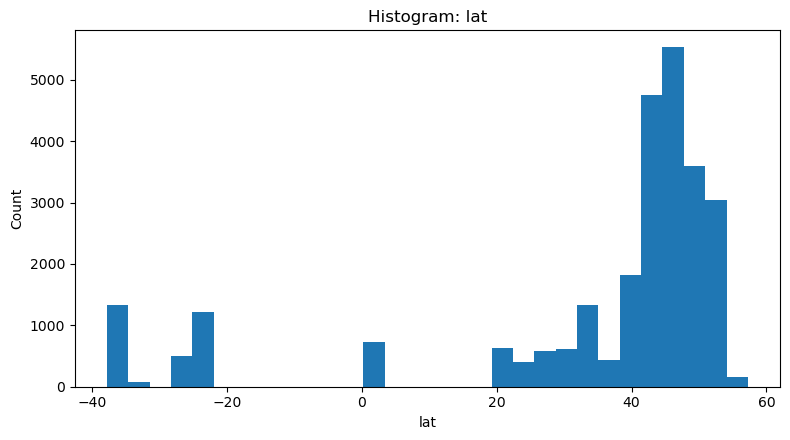

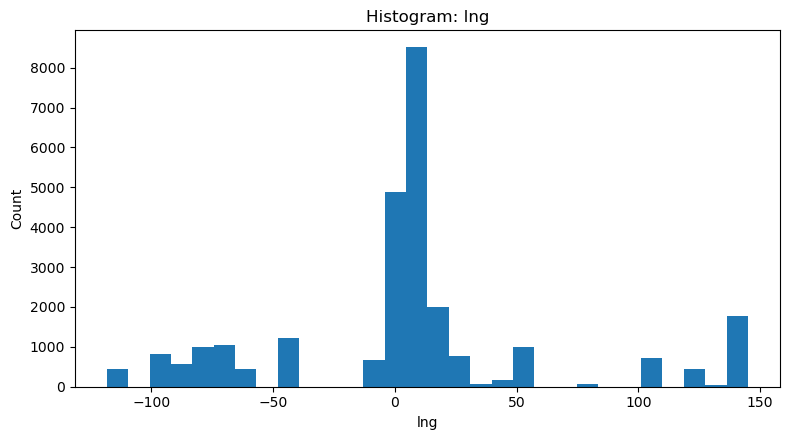

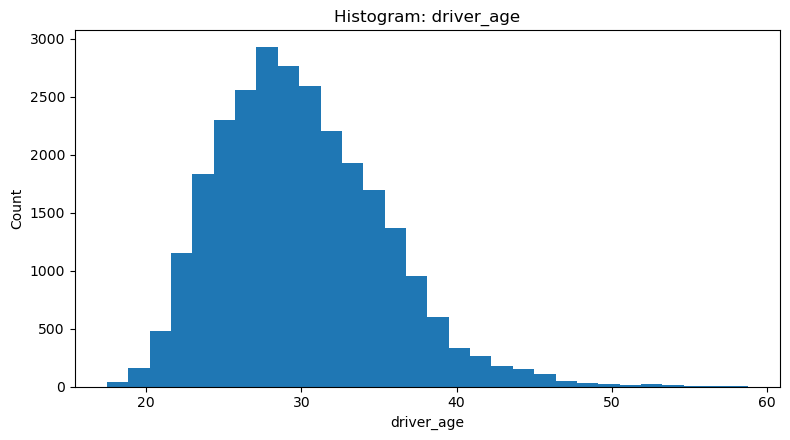

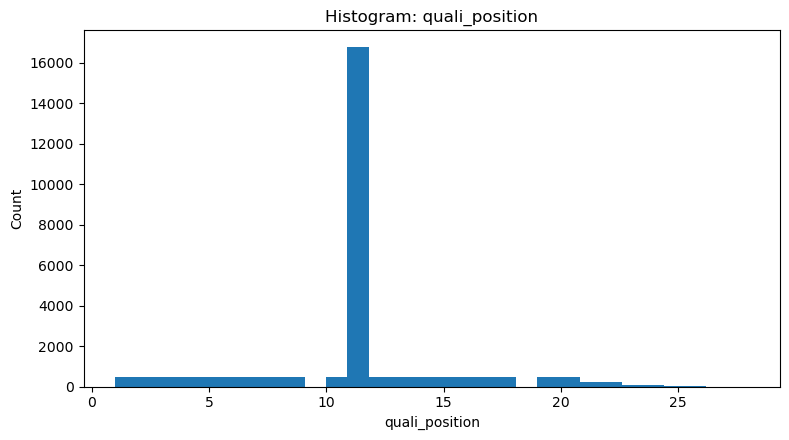

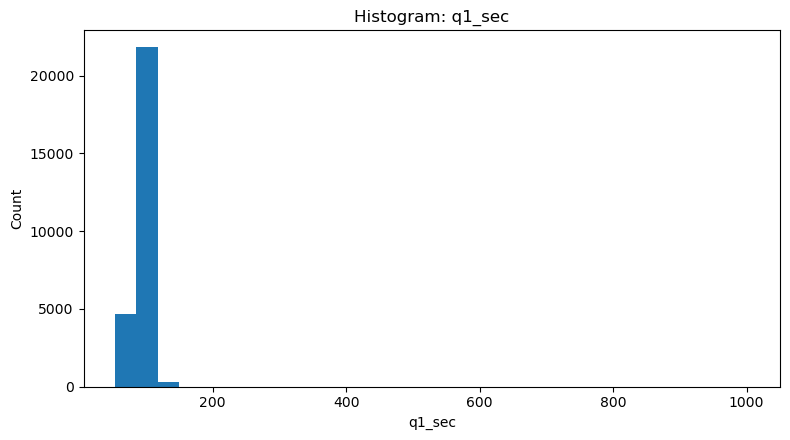

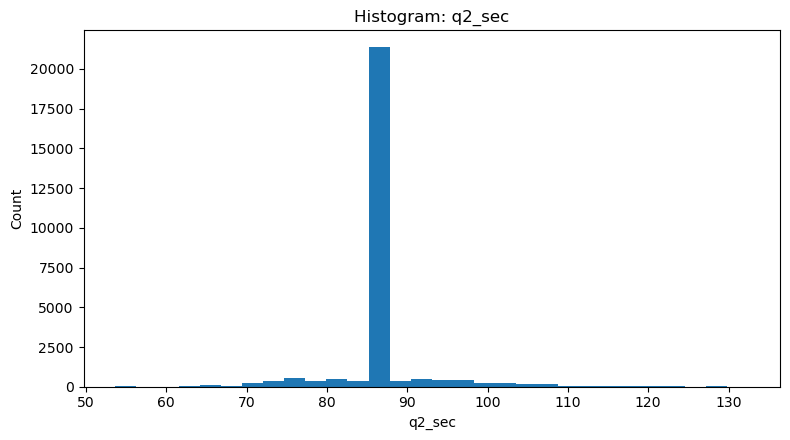

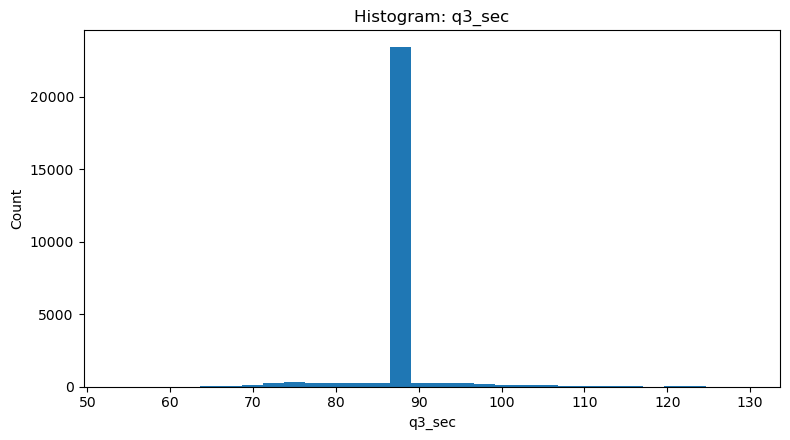

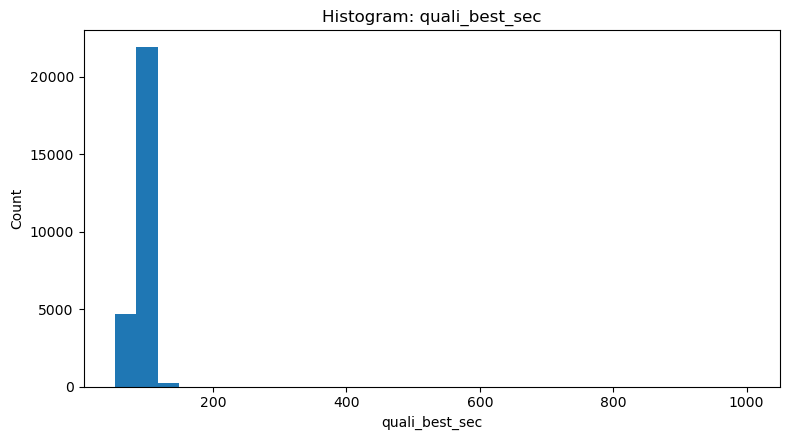

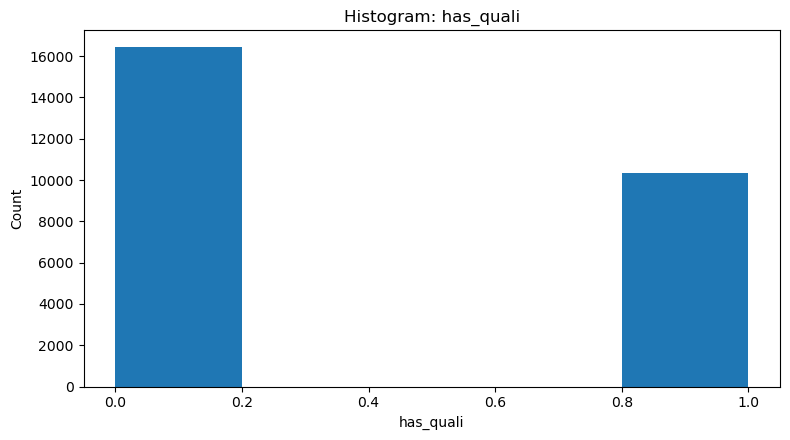

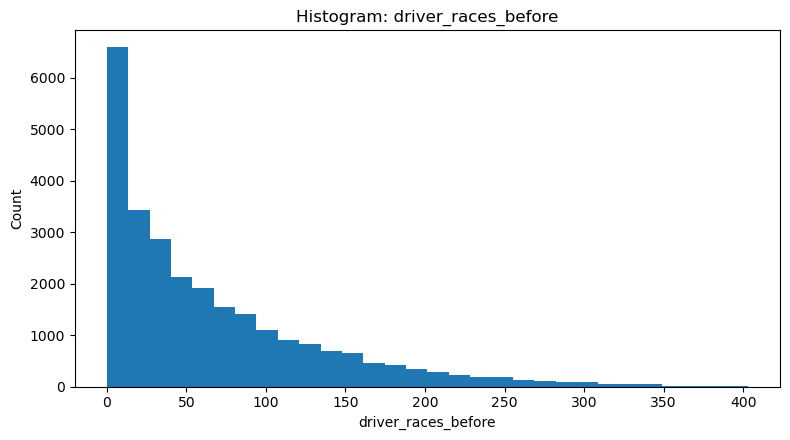

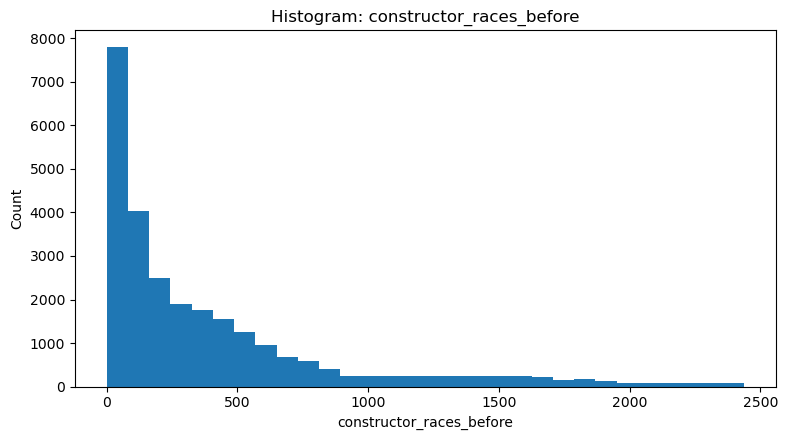

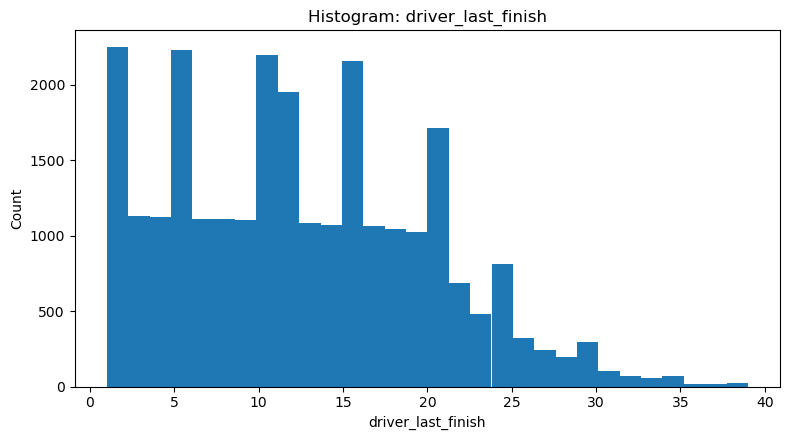

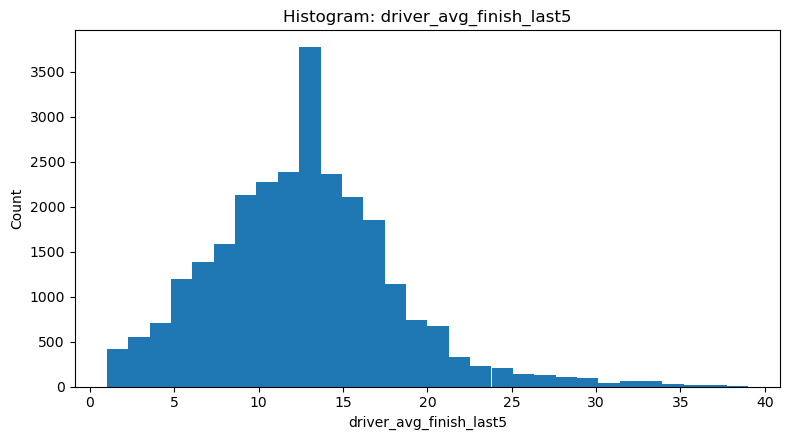

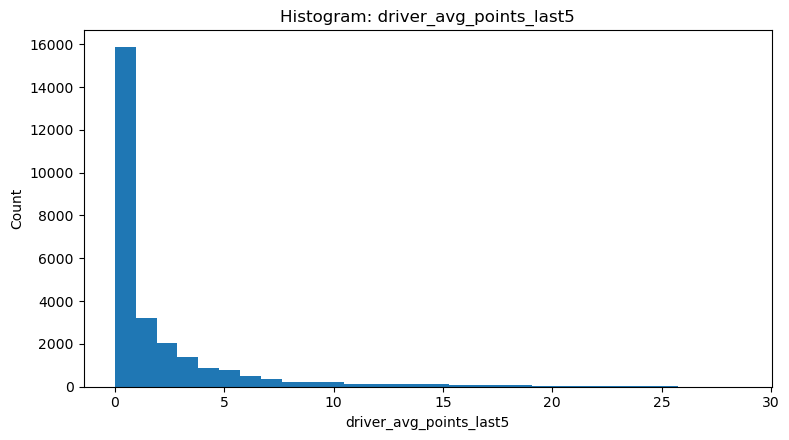

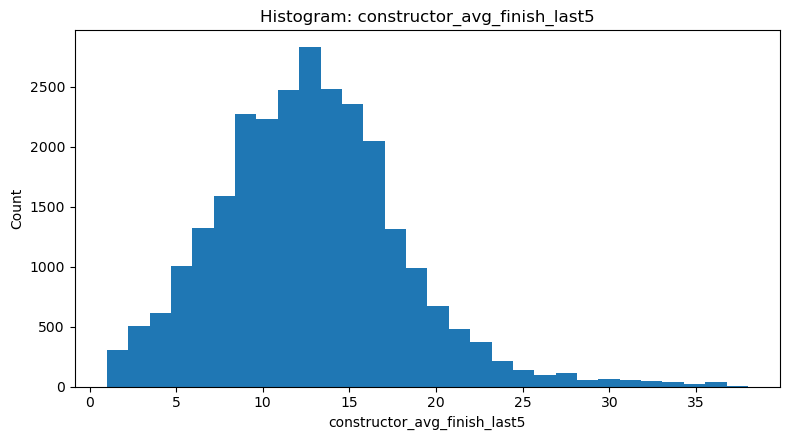

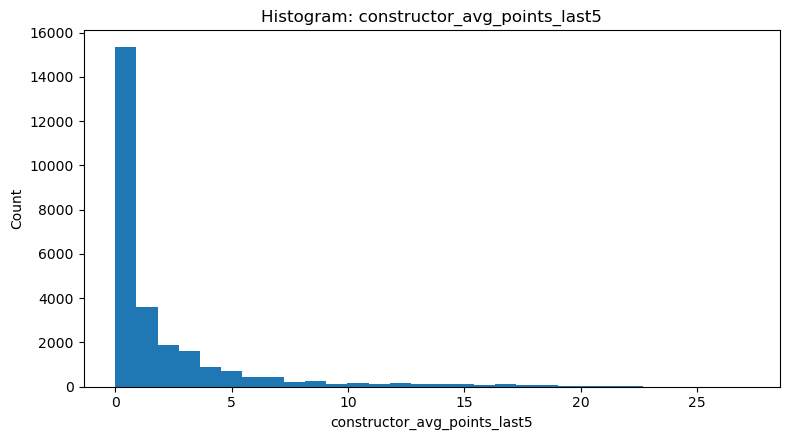

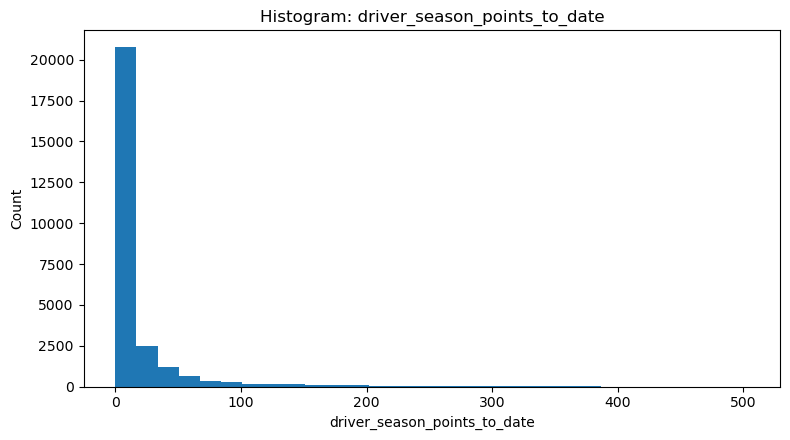

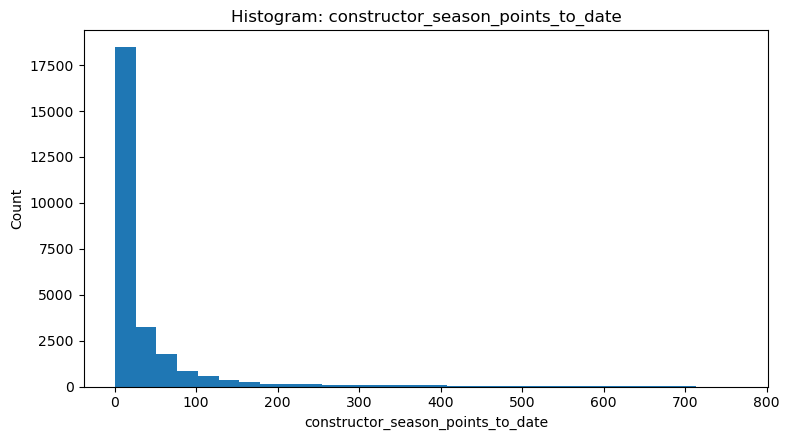

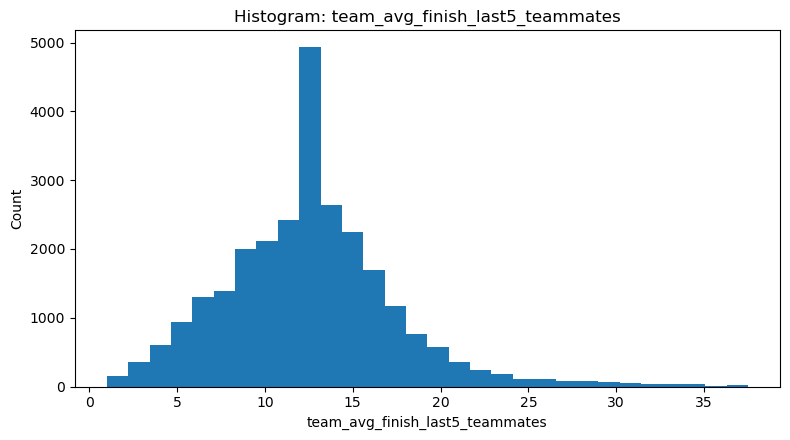

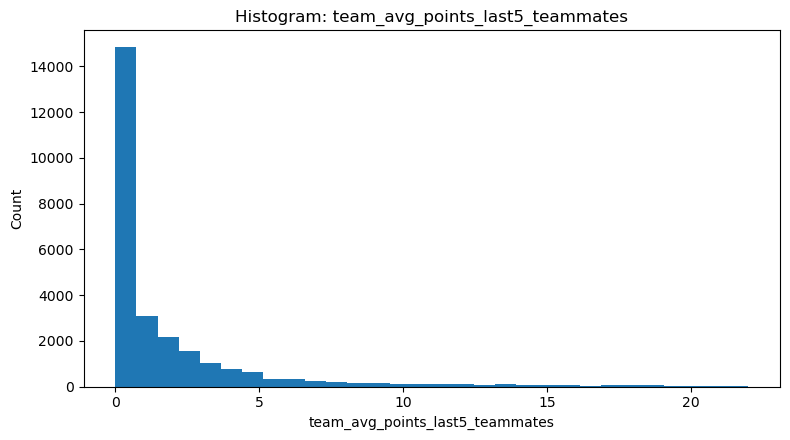

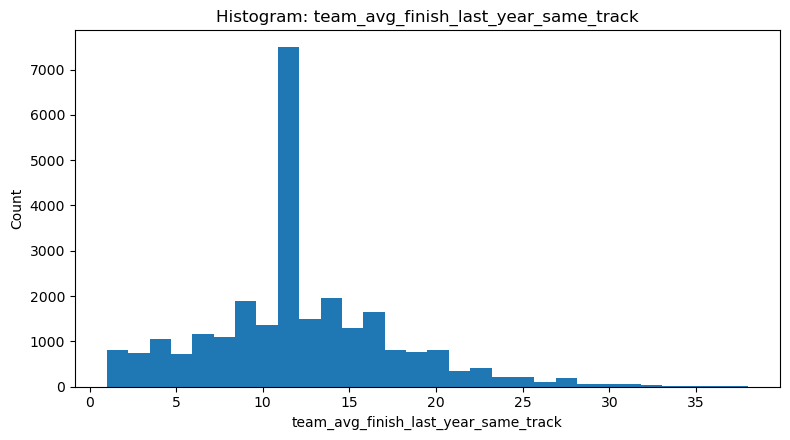

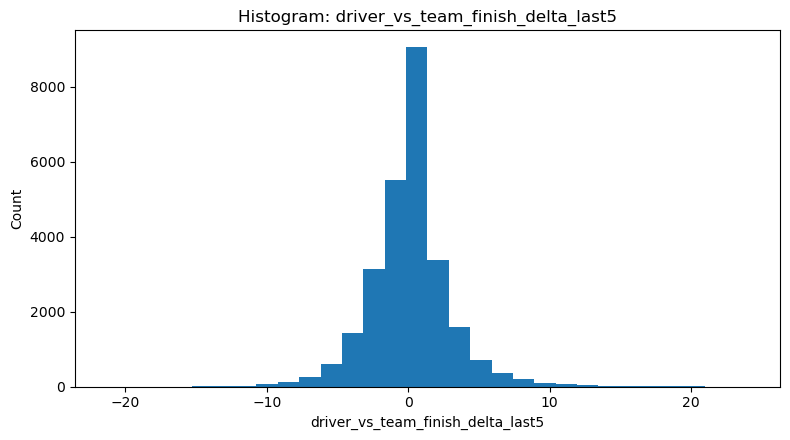

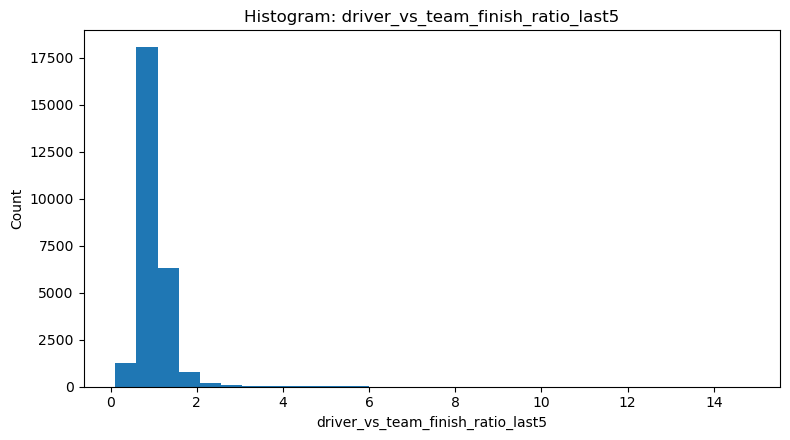

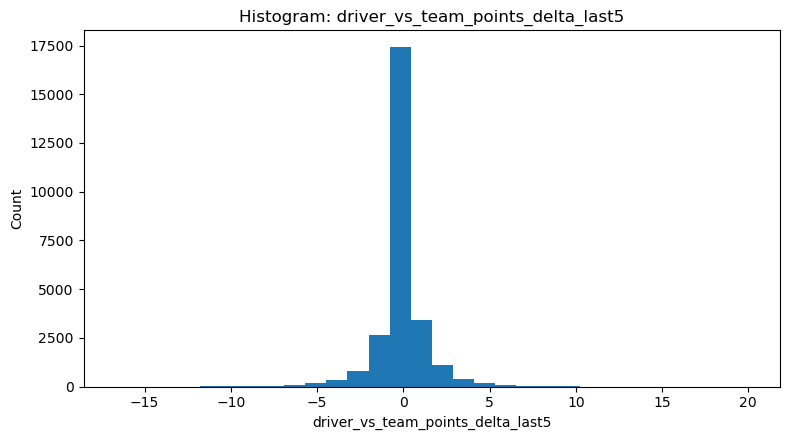

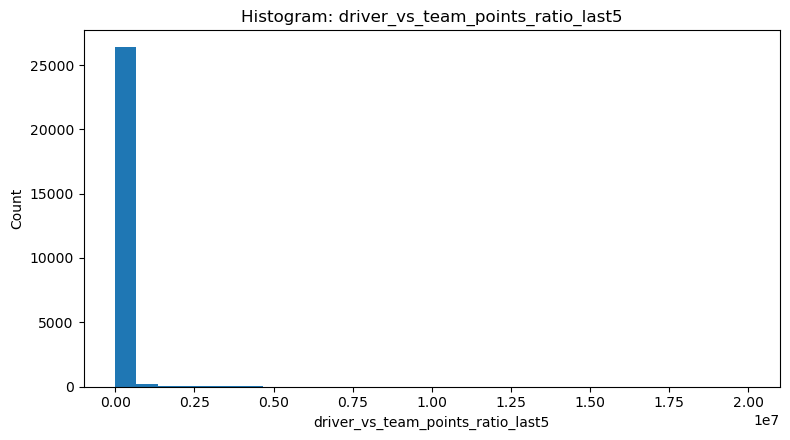

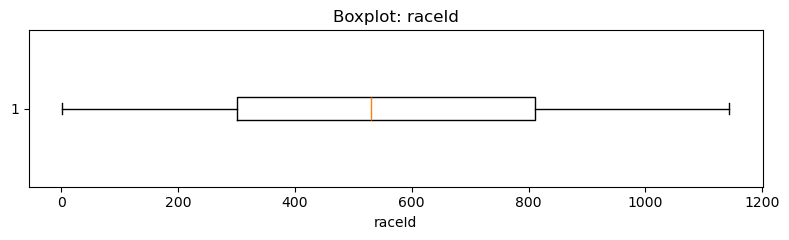

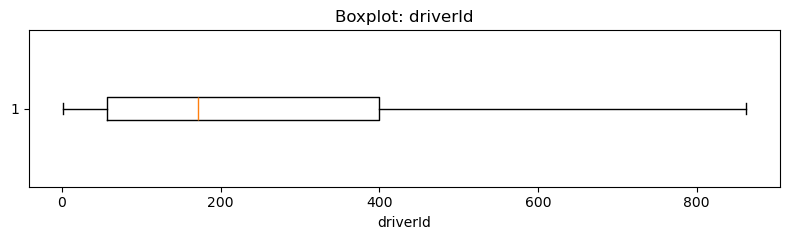

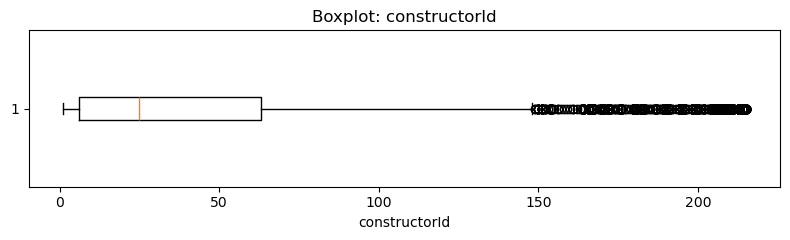

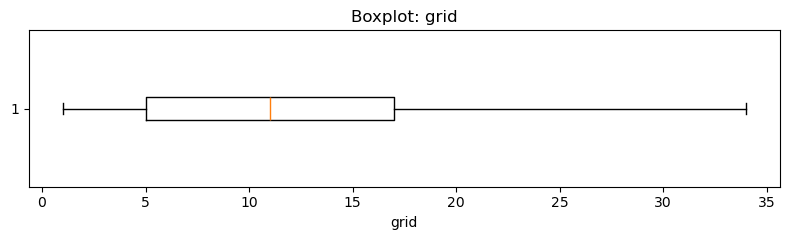

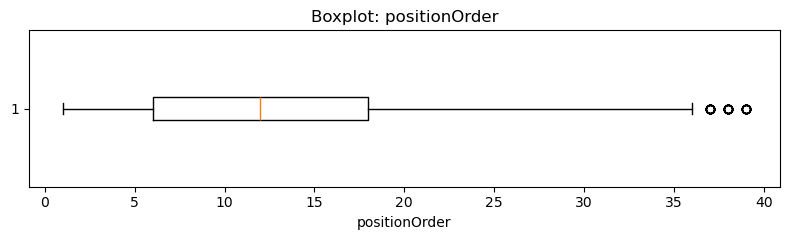

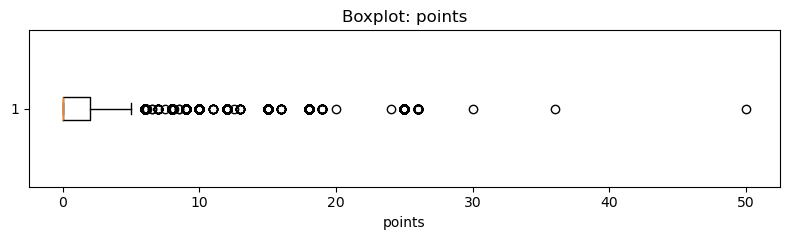

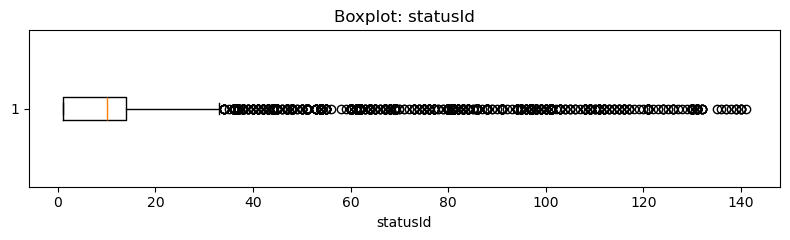

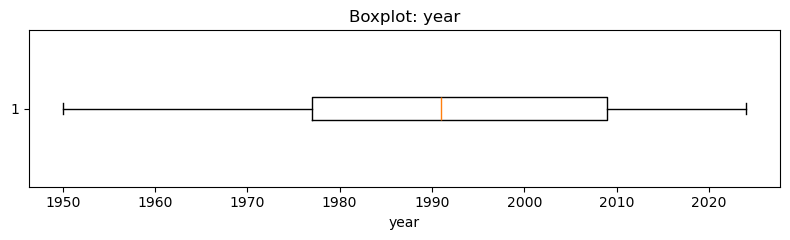

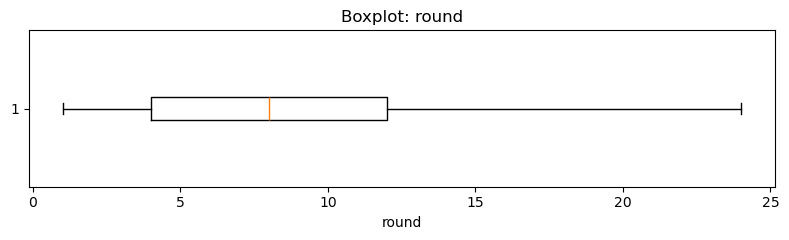

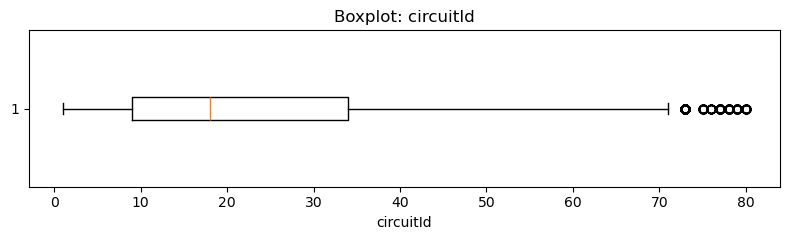

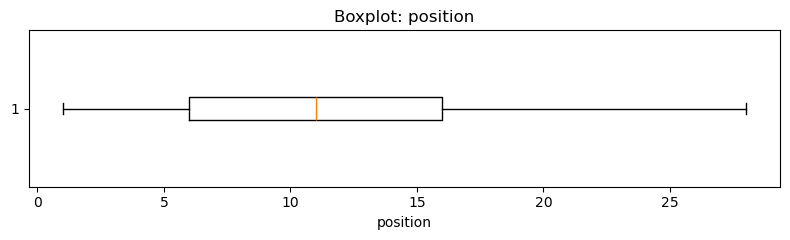

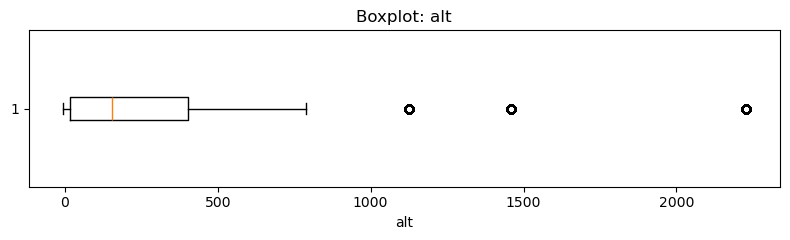

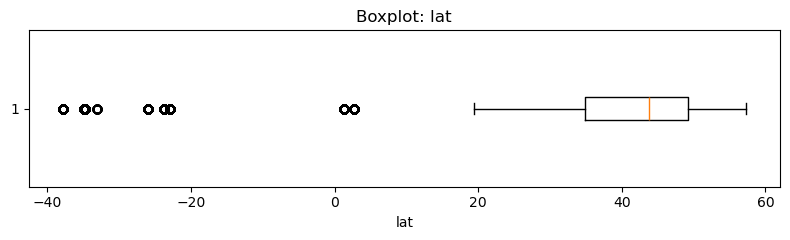

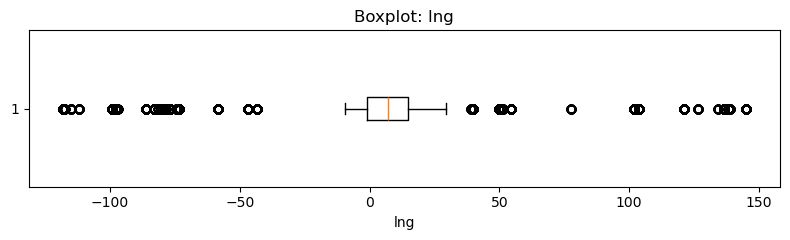

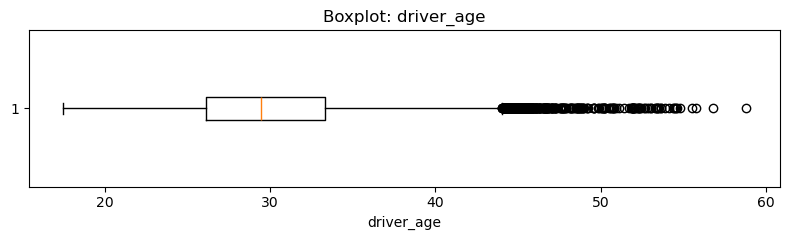

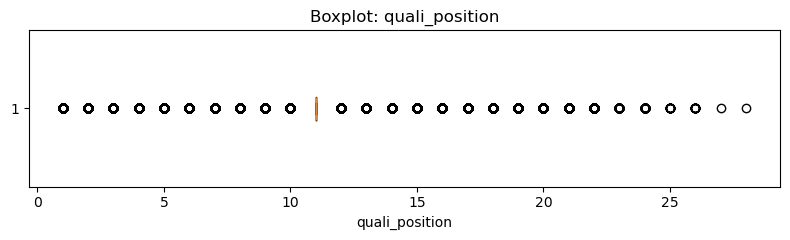

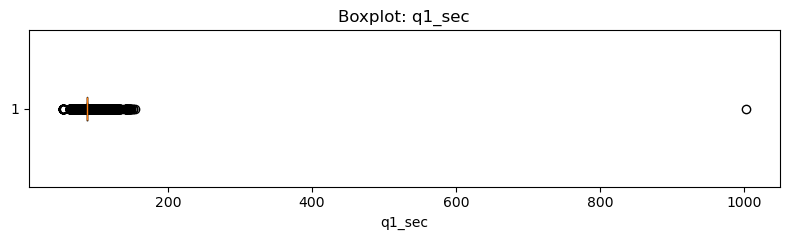

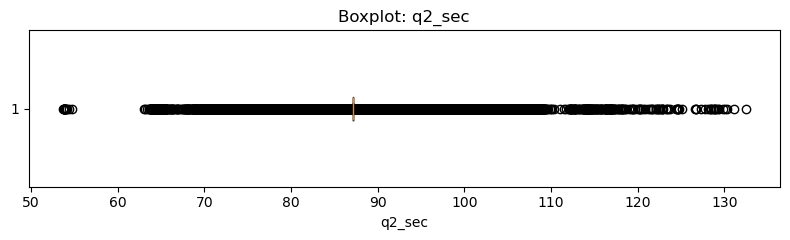

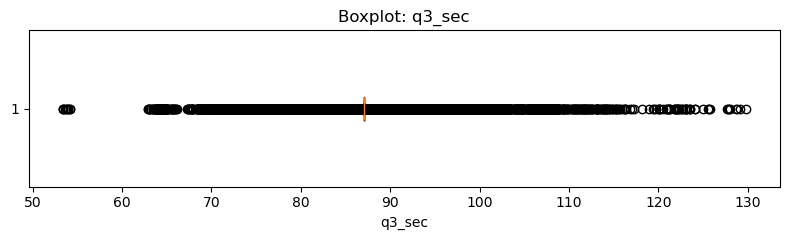

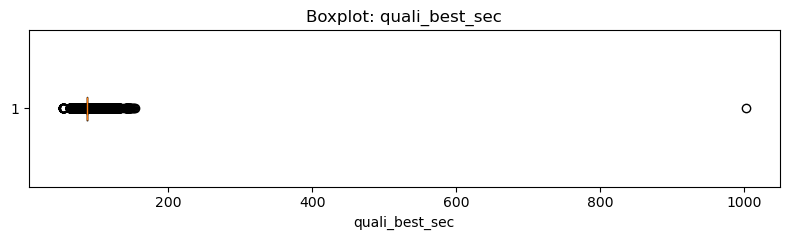

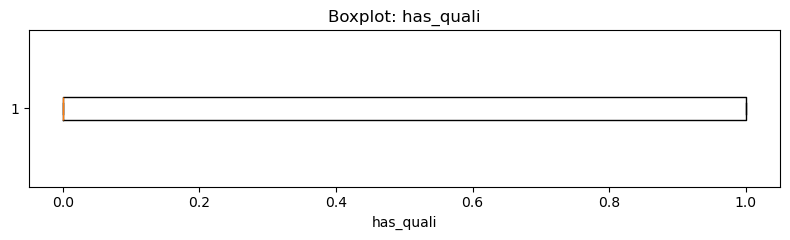

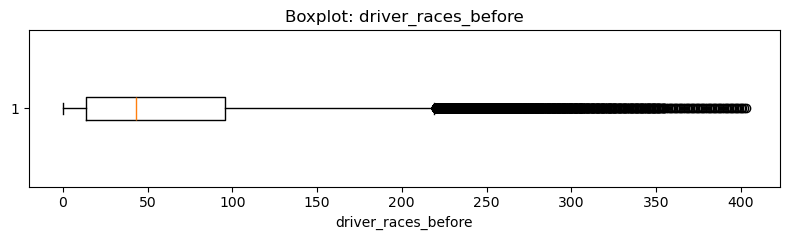

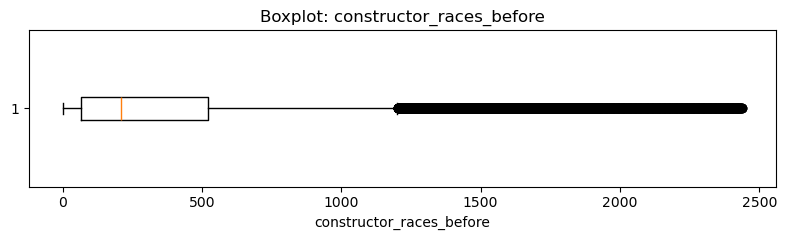

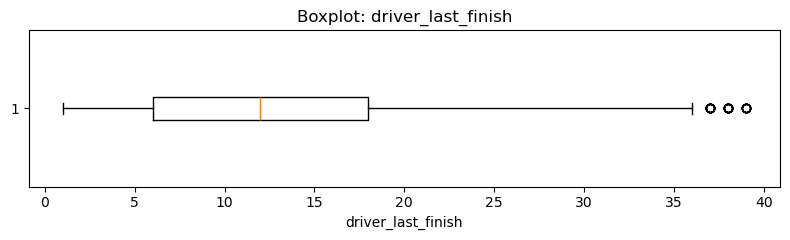

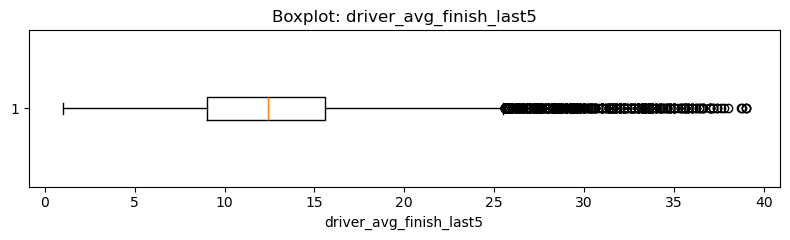

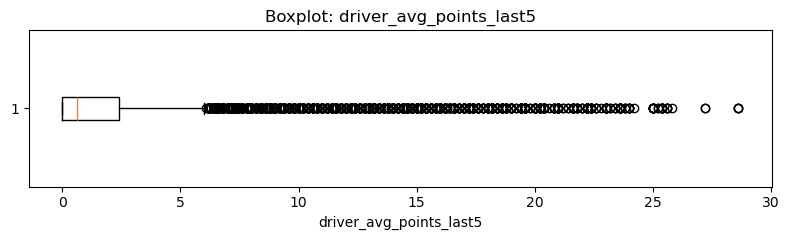

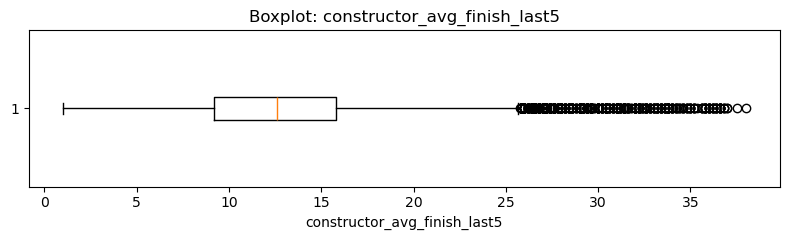

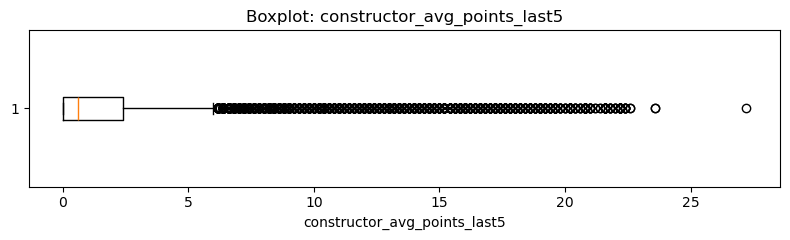

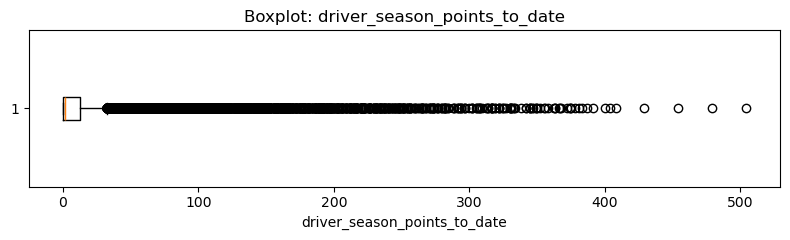

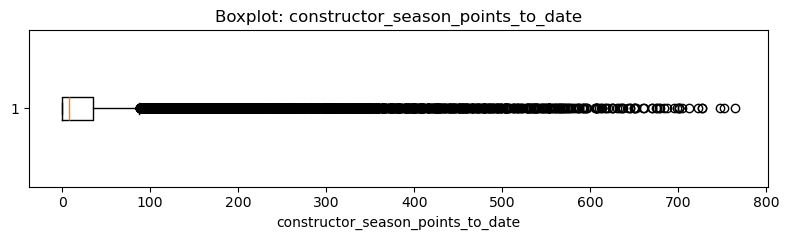

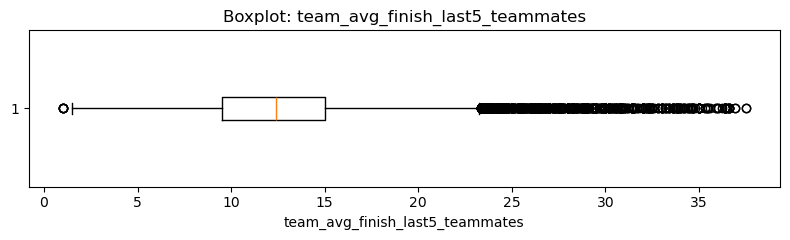

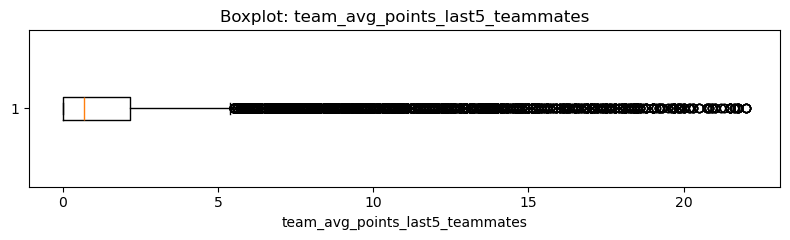

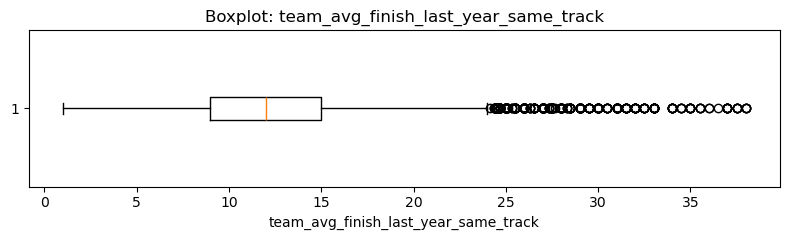

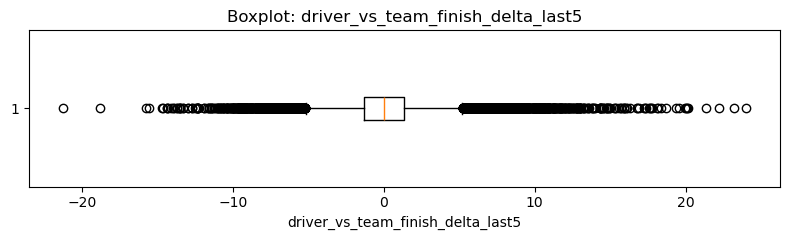

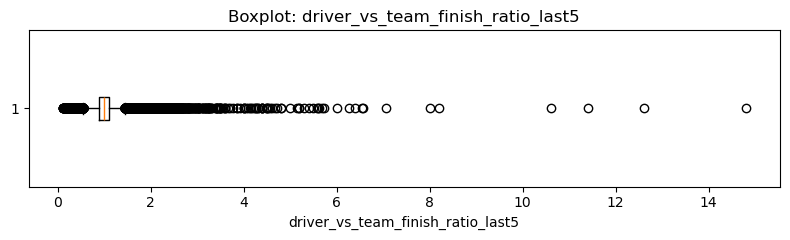

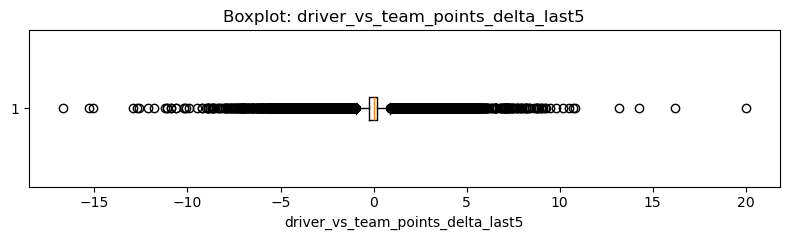

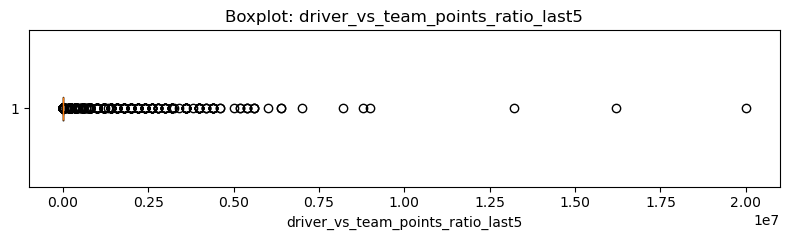

,q00,q01,q05,q25,q50,q75,q95,q99,q100
driver_vs_team_points_ratio_last5,0.000000,0.000000,0.000000,0.000000,0.666666,1.222222,2.502416,1000000.000000,2.000000e+07
alt,-7.000000,0.000000,6.000000,18.000000,153.000000,401.000000,1126.000000,2227.000000,2.227000e+03
constructor_races_before,0.000000,1.000000,8.000000,66.000000,210.000000,520.000000,1566.000000,2170.420000,2.438000e+03
year,1950.000000,1951.000000,1956.000000,1977.000000,1991.000000,2009.000000,2022.000000,2024.000000,2.024000e+03
raceId,1.000000,14.000000,64.000000,300.000000,531.000000,811.000000,1075.000000,1131.000000,1.144000e+03
driverId,1.000000,1.000000,8.000000,57.000000,172.000000,399.500000,840.000000,852.000000,8.620000e+02
constructor_season_points_to_date,0.000000,0.000000,0.000000,0.000000,8.000000,35.000000,168.000000,427.210000,7.640000e+02
driver_races_before,0.000000,0.000000,1.000000,14.000000,43.000000,96.000000,207.000000,298.000000,4.030000e+02
driver_season_points_to_date,0.000000,0.000000,0.000000,0.000000,2.000000,13.000000,84.000000,214.420000,5.040000e+02
constructorId,1.000000,1.000000,1.000000,6.000000,25.000000,63.000000,205.000000,213.000000,2.150000e+02


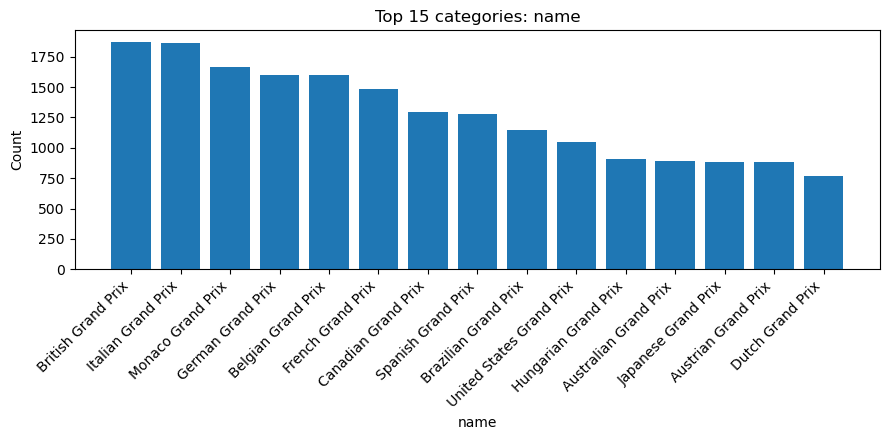

Skipping date (high cardinality: 1125)
Skipping dob (high cardinality: 843)


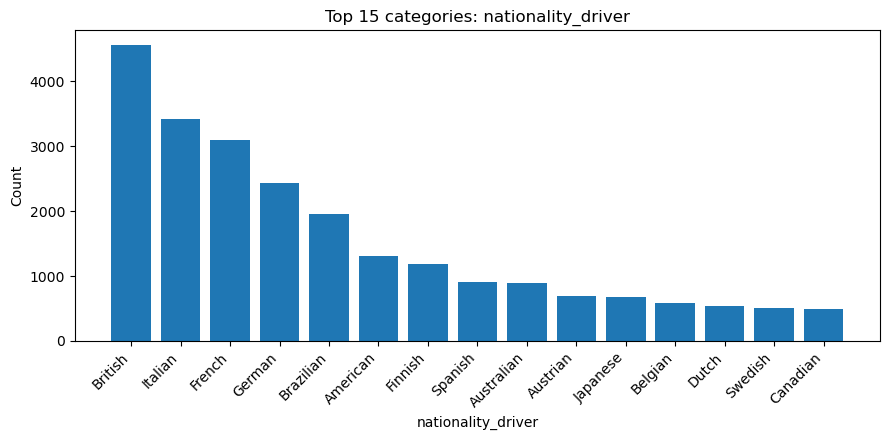

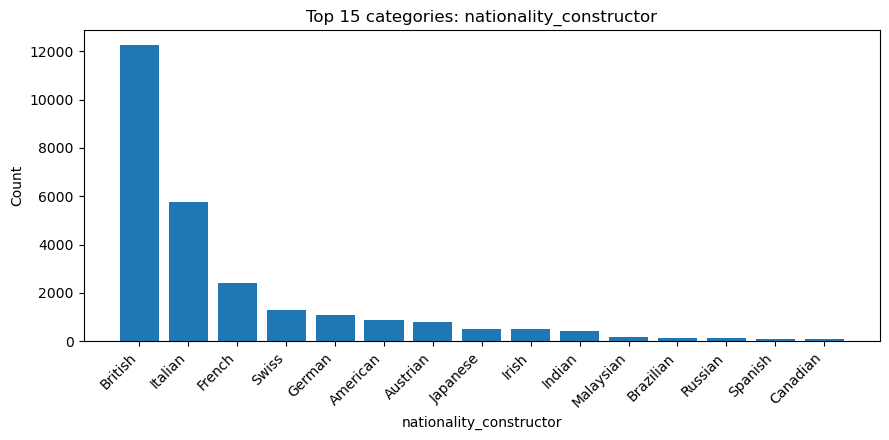

Skipping q1 (high cardinality: 9136)
Skipping q2 (high cardinality: 5473)
Skipping q3 (high cardinality: 3470)


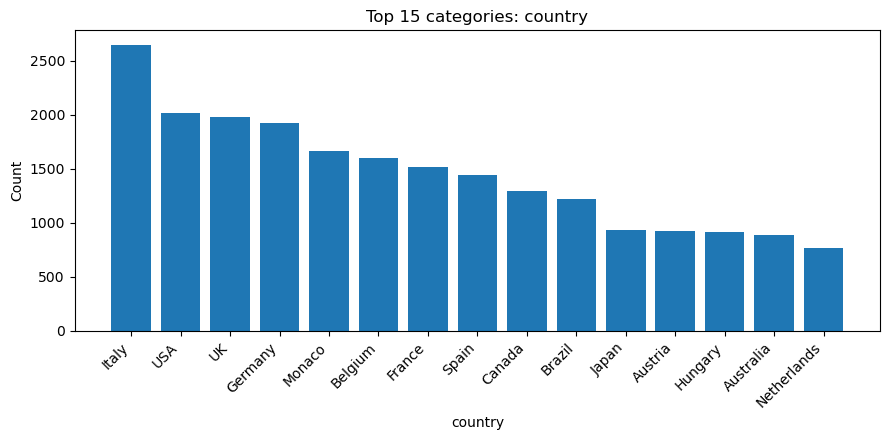

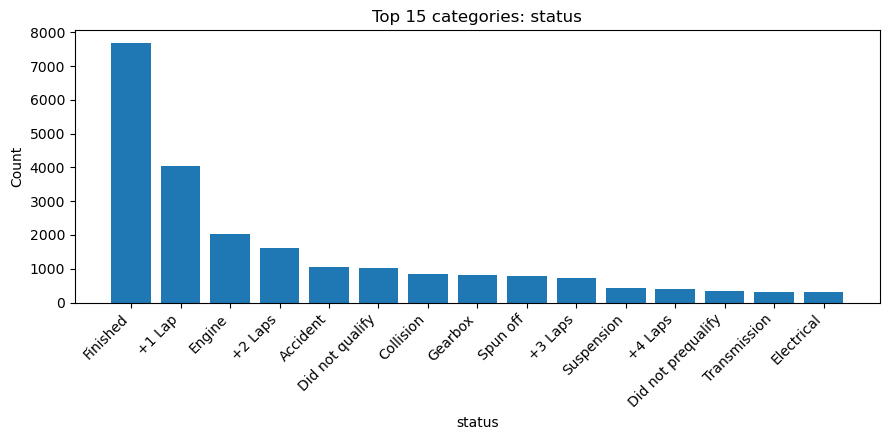

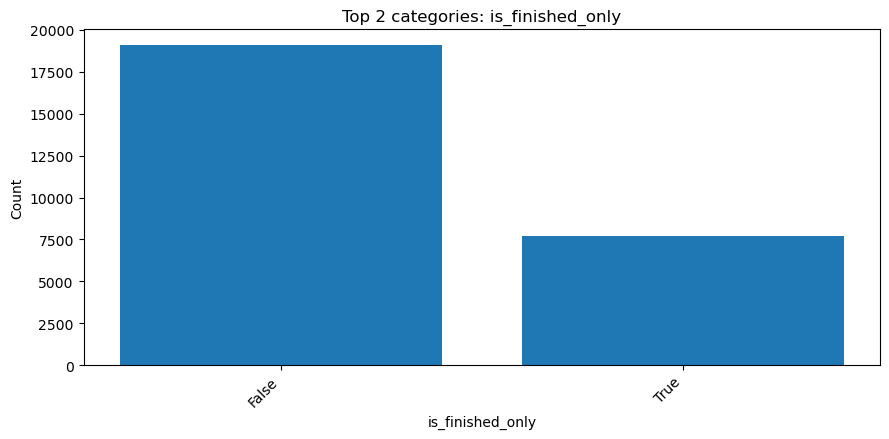

,dtype,missing_count,missing_%,n_unique
q3,object,23130,86.44,3470
q2,object,20912,78.15,5473
q1,object,16431,61.40,9136
position,float64,16275,60.82,28


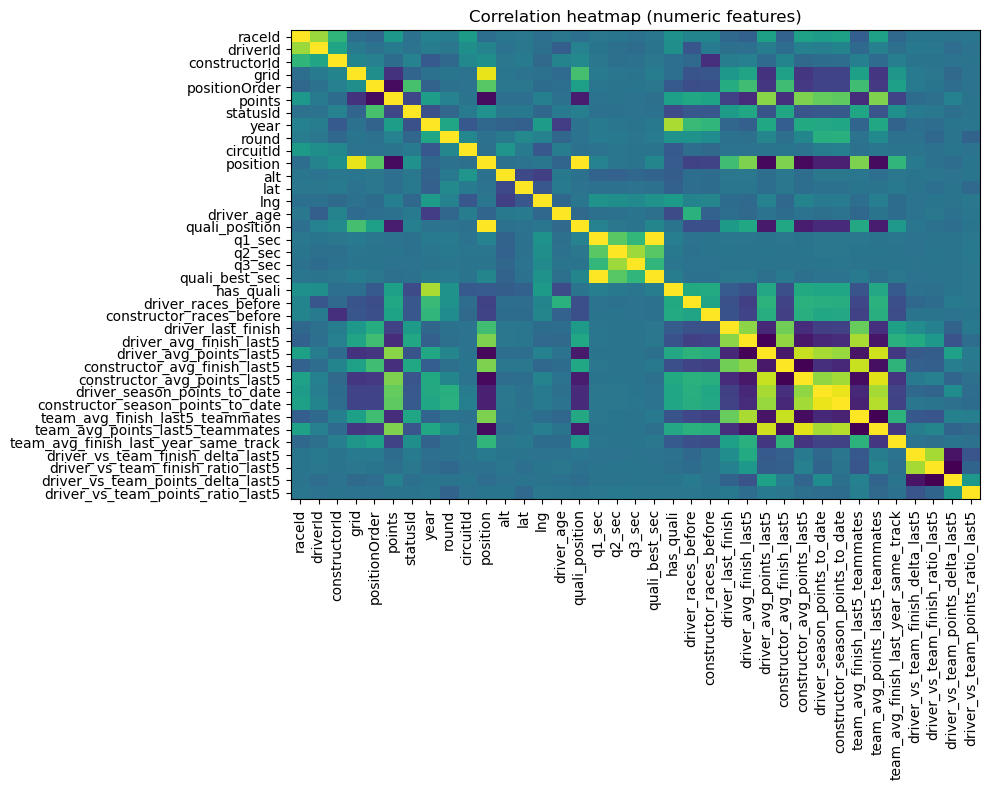

,feature_1,feature_2,abs_corr
0,position,quali_position,1.000000
1,q1_sec,quali_best_sec,0.994488
2,driver_season_points_to_date,constructor_season_points_to_date,0.953909
3,grid,position,0.946394
4,constructor_avg_points_last5,team_avg_points_last5_teammates,0.924936
5,driver_avg_points_last5,team_avg_points_last5_teammates,0.884713
6,driver_avg_points_last5,constructor_avg_points_last5,0.863898
7,constructor_avg_finish_last5,team_avg_finish_last5_teammates,0.863654
8,constructor_season_points_to_date,team_avg_points_last5_teammates,0.819796
9,driver_avg_finish_last5,team_avg_finish_last5_teammates,0.792480


In [186]:
## Understanding distribution of features
# ================================
# Understanding distribution of features
# ================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- 0) Pick your dataframe ----
# Change this to whatever you use in your notebook (examples: df, data, merged_df, model_df, train_df)
try:
    df  # noqa: F821
except NameError:
    raise NameError("Define your dataframe first (e.g., df = model_df). Then re-run this cell.")

# Optional: keep only columns you actually model on (exclude obvious IDs/text if you want)
# comment this out if you already have the right df
# drop_cols = [c for c in df.columns if c.lower().endswith("id")] + ["url", "name"]
# df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

print("Shape:", df.shape)
display(df.head())

# ---- 1) Basic summary ----
summary = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "missing_count": df.isna().sum(),
    "missing_%": (df.isna().mean() * 100).round(2),
    "n_unique": df.nunique(dropna=True),
})
display(summary.sort_values(["missing_%", "n_unique"], ascending=[False, False]).head(30))

# ---- 2) Separate numeric vs categorical ----
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in df.columns if c not in numeric_cols]

print(f"Numeric cols: {len(numeric_cols)}")
print(f"Categorical/other cols: {len(cat_cols)}")

# ---- 3) Numeric feature distributions (histograms) ----
# Tip: this can produce many plots if you have lots of numeric columns
max_numeric_plots = 40  # adjust
for col in numeric_cols[:max_numeric_plots]:
    s = df[col].dropna()
    if s.empty:
        continue

    # Choose bins safely
    bins = 30
    if s.nunique() <= 10:
        bins = int(max(5, min(30, s.nunique())))

    plt.figure(figsize=(8, 4.5))
    plt.hist(s, bins=bins)
    plt.title(f"Histogram: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ---- 4) Numeric feature boxplots (spot outliers quickly) ----
max_boxplots = 40  # adjust
for col in numeric_cols[:max_boxplots]:
    s = df[col].dropna()
    if s.empty:
        continue

    plt.figure(figsize=(8, 2.5))
    plt.boxplot(s, vert=False)
    plt.title(f"Boxplot: {col}")
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# ---- 5) Quantiles table for numeric columns (helps understand skew/outliers) ----
if numeric_cols:
    quantiles = df[numeric_cols].quantile([0.00, 0.01, 0.05, 0.25, 0.50, 0.75, 0.95, 0.99, 1.00]).T
    quantiles.columns = [f"q{int(q*100):02d}" for q in quantiles.columns]
    display(quantiles.sort_values("q99", ascending=False).head(30))

# ---- 6) Categorical feature distributions (top categories bar chart) ----
max_cat_plots = 30   # adjust
top_k = 15           # show top K categories per column

for col in cat_cols[:max_cat_plots]:
    s = df[col].dropna()
    if s.empty:
        continue

    # If it's high-cardinality (like unique IDs), skip
    nunq = s.nunique()
    if nunq > 200:
        print(f"Skipping {col} (high cardinality: {nunq})")
        continue

    vc = s.value_counts().head(top_k)

    plt.figure(figsize=(9, 4.5))
    plt.bar(vc.index.astype(str), vc.values)
    plt.title(f"Top {min(top_k, nunq)} categories: {col}")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# ---- 7) Missingness overview (columns with missing values) ----
missing_cols = summary[summary["missing_count"] > 0].sort_values("missing_%", ascending=False)
display(missing_cols.head(50))

# ---- 8) Correlation (numeric only) ----
# Shows where numeric features may be strongly related (or redundant)
if len(numeric_cols) >= 2:
    corr = df[numeric_cols].corr(numeric_only=True)

    plt.figure(figsize=(10, 8))
    plt.imshow(corr.values, aspect="auto")
    plt.title("Correlation heatmap (numeric features)")
    plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
    plt.yticks(range(len(numeric_cols)), numeric_cols)
    plt.tight_layout()
    plt.show()

    # Top absolute correlations (excluding self-correlation)
    corr_abs = corr.abs().where(np.triu(np.ones(corr.shape), k=1).astype(bool))
    top_pairs = (
        corr_abs.stack()
        .sort_values(ascending=False)
        .head(20)
        .reset_index()
        .rename(columns={"level_0": "feature_1", "level_1": "feature_2", 0: "abs_corr"})
    )
    display(top_pairs)
else:
    print("Not enough numeric columns for correlation analysis.")


In this section, I explored the distribution of features using histograms/boxplots (numeric) and value-count plots (categorical) to understand how the dataset behaves before modelling. This helps confirm whether features are skewed, contain outliers, or represent bounded/rule-based values, and it also highlights where preprocessing decisions (encoding, scaling, imputation strategy) must be justified rather than done “blindly”.

A key observation is that several “missing” values are not errors, but structural missingness caused by Formula 1 qualifying rules. For example, Q2 and Q3 times are naturally absent for drivers who did not advance past Q1/Q2, and in some edge cases a driver can also have no valid recorded time due to incidents, disqualifications, or not setting a representative lap. Therefore, the high missingness percentage in q2 and q3 is expected and meaningful — it actually represents performance/qualification outcome rather than incomplete data collection. Because of this, these NaNs shouldn’t automatically be treated as a data quality problem; instead they should be handled in a way that preserves their meaning (e.g., stage-aware imputation, sentinel values, or “reached_Q2/reached_Q3” indicator variables).

For position, it’s important to interpret it correctly relative to your pipeline. Since the notebook shows position after imputation, any missingness shown there is not necessarily “raw missingness”; it reflects how the imputation step filled values and what patterns remain afterward. This is why distribution checks are still useful post-imputation: they help verify that imputation didn’t create unrealistic values (e.g., fractional ranks, impossible ranges, or a suspicious spike at a single fill value). The boxplots and quantiles also help confirm whether extreme values represent real race events (DNFs, unusual results) or preprocessing artifacts.

Lastly, the correlation results show that several performance-related variables are highly correlated (e.g., qualifying and grid/position-type features). This is expected because many of these fields describe closely related outcomes. The analysis justifies careful feature selection or regularisation to avoid redundancy, and it also signals which variables could accidentally introduce leakage if the goal is to predict outcomes using only information available before the race.

Conclusion: This distribution analysis supports preprocessing choices that are domain-aware (qualifying stages produce legitimate NaNs), checks that imputation behaves sensibly (especially for position), and informs modelling decisions around redundant/strongly correlated performance features.

## 3.2 Train-Test Split

In [189]:
# Use modern era (qualifying data is reliable)
df_model = df[df["year"] >= 2006].copy()
df_model["date"] = pd.to_datetime(df_model["date"], errors="coerce")



In [190]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
feature_cols = [
    "year","round","circuitId","alt","lat","lng",
    "grid","has_quali","quali_position","quali_best_sec",
    "driver_age",
    "driver_races_before","constructor_races_before",
    "driver_last_finish","driver_avg_finish_last5","driver_avg_points_last5",
    "constructor_avg_finish_last5","constructor_avg_points_last5",

    # ✅ car strength
    "team_avg_finish_last5_teammates",
    "team_avg_points_last5_teammates", 
    "team_avg_finish_last_year_same_track",

    # ✅ driver outperforming car
    "driver_vs_team_finish_delta_last5",
    "driver_vs_team_finish_ratio_last5",
    "driver_vs_team_points_delta_last5",
    "driver_vs_team_points_ratio_last5",

    "driver_season_points_to_date","constructor_season_points_to_date",
    "driverId","constructorId","country"
]

# ----------------------------
# 1) Choose dataset + split
# ----------------------------
df_model = df[df["year"] >= 2006].copy()
df_model["date"] = pd.to_datetime(df_model["date"], errors="coerce")

cutoff = df_model["date"].quantile(0.8)
train_idx = df_model["date"] <= cutoff
test_idx  = df_model["date"] > cutoff

print("Train rows:", int(train_idx.sum()), "| Test rows:", int(test_idx.sum()))
print("Cutoff date:", cutoff.date())

# ----------------------------
# 2) Features + target (must match your updated feature_cols cell)
# ----------------------------
target = "positionOrder"

missing_feat = [c for c in feature_cols if c not in df_model.columns] 
if missing_feat:
    raise ValueError("Missing from df_model (did you run feature engineering + imputation first?):\n" + str(missing_feat))

X_raw = df_model[feature_cols].copy()
y = df_model[target].astype(float).copy()

X = pd.get_dummies(
    X_raw,
    columns=["driverId","constructorId","circuitId","country"],
    drop_first=True
)

# Fill remaining NaNs
for c in X.columns:
    if pd.api.types.is_numeric_dtype(X[c]):
        X[c] = X[c].fillna(X[c].median())

X_train, X_test = X.loc[train_idx], X.loc[test_idx]
y_train, y_test = y.loc[train_idx], y.loc[test_idx]

X_columns = X.columns
grid_test = df_model.loc[test_idx, "grid"].astype(float).values

# ----------------------------
# 3) Models
# ----------------------------
hgb = HistGradientBoostingRegressor(loss="absolute_error", random_state=2025)
gbr = GradientBoostingRegressor(random_state=2025)

rf  = RandomForestRegressor(
    n_estimators=400,
    random_state=2025,
    n_jobs=-1,
    min_samples_leaf=2
)

dt  = DecisionTreeRegressor(
    random_state=2025,
    max_depth=12,
    min_samples_leaf=5
)

lin = LinearRegression()

models = {
    "HistGradientBoosting(abs_error)": hgb,
    "GradientBoostingRegressor": gbr,
    "RandomForestRegressor": rf,
    "DecisionTreeRegressor": dt,
    "LinearRegression": lin
}

# ----------------------------
# 4) Metrics helper
# ----------------------------
def evaluate_predictions(name, y_true, pred):
    y_true = np.asarray(y_true).astype(float)
    pred = np.asarray(pred).astype(float)

    abs_err = np.abs(y_true - pred)

    mae = mean_absolute_error(y_true, pred)
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    median_ae = np.median(abs_err)

    thr95 = np.quantile(abs_err, 0.95)
    trim_mae_95 = abs_err[abs_err <= thr95].mean()

    within1 = (abs_err <= 1).mean()
    within2 = (abs_err <= 2).mean()
    within3 = (abs_err <= 3).mean()
    within5 = (abs_err <= 5).mean()

    pred_round = np.clip(np.rint(pred), 1, 40)
    exact_pct = (np.abs(y_true - pred_round) == 0).mean()

    spearman = pd.Series(y_true).corr(pd.Series(pred), method="spearman")

    return {
        "model": name,
        "rows_used": len(y_true),
        "MAE": mae,
        "RMSE": rmse,
        "MedianAE": median_ae,
        "TrimMAE95": trim_mae_95,
        "P95_abs_err": thr95,
        "Within±1": within1,
        "Within±2": within2,
        "Within±3": within3,
        "Within±5": within5,
        "Exact(rounded)%": exact_pct,
        "Spearman": spearman
    }

# ----------------------------
# 5) Train + predict + compare
# ----------------------------
preds = {}

for name, m in models.items():
    m.fit(X_train, y_train)
    preds[name] = m.predict(X_test)

preds["Baseline(grid)"] = grid_test

rows_full = [evaluate_predictions(name, pred_y, pred_vals) for name, pred_vals in preds.items() for pred_y in [y_test.values]]
compare_full = pd.DataFrame(rows_full).set_index("model").sort_values("MAE")

print("\n=== FULL TEST METRICS ===")
display(compare_full)

best_model_name_no_baseline = (
    compare_full.drop(index=["Baseline(grid)"], errors="ignore").index[0]
)
print("\nBest model by MAE (excluding baseline):", best_model_name_no_baseline)

best_model = models[best_model_name_no_baseline]
best_pred = preds[best_model_name_no_baseline]

# Named preds
hgb_pred = preds["HistGradientBoosting(abs_error)"]
gbr_pred = preds["GradientBoostingRegressor"]
rf_pred  = preds["RandomForestRegressor"]
dt_pred  = preds["DecisionTreeRegressor"]
lin_pred = preds["LinearRegression"]
baseline_pred = preds["Baseline(grid)"]

print("\nSaved preds: hgb_pred, gbr_pred, rf_pred, dt_pred, lin_pred, baseline_pred, best_pred")
print("Saved: X_columns, feature_cols")
print("\nSaved: hgb_before_fe, before_fe_cutoff, before_fe_train_rows, before_fe_test_rows, base_feature_cols, base_X_columns")
print("\n=== BEFORE FEATURE ENGINEERING (BASELINE) METRICS TABLE ===")
display(report)


Train rows: 6335 | Test rows: 1579
Cutoff date: 2021-08-01

=== FULL TEST METRICS ===


,rows_used,MAE,RMSE,MedianAE,TrimMAE95,P95_abs_err,Within±1,Within±2,Within±3,Within±5,Exact(rounded)%,Spearman
model,,,,,,,,,,,,
HistGradientBoosting(abs_error),1579,2.989950,4.306484,2.037527,2.454393,9.734240,0.265991,0.492717,0.647245,0.830906,0.134262,0.686565
GradientBoostingRegressor,1579,3.534735,4.402927,2.956016,3.163982,8.468504,0.162761,0.328056,0.507283,0.754275,0.074098,0.655857
RandomForestRegressor,1579,3.634427,4.489329,3.180438,3.257325,8.493727,0.143762,0.309690,0.473718,0.746675,0.072831,0.645225
Baseline(grid),1579,3.697277,5.432993,2.000000,3.100930,13.000000,0.360355,0.522483,0.633946,0.781507,0.150095,0.559051
LinearRegression,1579,3.887790,5.085532,2.988260,3.406986,11.011159,0.169094,0.328689,0.501583,0.723876,0.088664,0.542140
DecisionTreeRegressor,1579,4.118407,5.453889,3.120968,3.607076,11.891071,0.183027,0.354022,0.496517,0.705510,0.086130,0.465597



Best model by MAE (excluding baseline): HistGradientBoosting(abs_error)

Saved preds: hgb_pred, gbr_pred, rf_pred, dt_pred, lin_pred, baseline_pred, best_pred
Saved: X_columns, feature_cols

Saved: hgb_before_fe, before_fe_cutoff, before_fe_train_rows, before_fe_test_rows, base_feature_cols, base_X_columns

=== BEFORE FEATURE ENGINEERING (BASELINE) METRICS TABLE ===


,rows_used,MAE,RMSE,Within±1,Within±3,Within±5,Exact(rounded)%,Spearman
model,,,,,,,,
HistGradientBoosting(abs_error) — BEFORE FE,1579,3.04252,4.332581,0.260291,0.632679,0.834072,0.139962,0.676862


Feature engineering produced a small but real improvement for the HistGradientBoosting(abs_error) model. Before FE, HGB’s MAE was 3.04252, meaning the model’s predicted finishing position was off by about 3 places on average. After FE, the MAE drops to 2.98995, so the average error improves to just under 3 places. That’s a reduction of about 0.0526 positions (roughly 1.7% improvement), which is why you can say FE helped — but only slightly, not dramatically. In other words, the engineered features added some extra predictive signal but more importanly it opens up new possiblity such as predicting unseen configurations such as Max Verstappen originally from redbull able to be in HAAS F1 Team instead for predicting unseendata and will accurately and realisticly predict the change as the feature engineering accounts for how much the driver outperforms the car so it can bring over to a new team and it wont be dramatically unrealstic and if you put another driver in the Haas such as Hamilton in the 2024 season for example it will account for driver perfroamce difference and predict a different nu,ber based on who the driver is as well and will know the car performance as well

# 4. Modelling

# 5. Model Evaluation

In [191]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error

def metrics_block_finished_only(
    name,
    y_true,
    pred_vals,
    meta_df: pd.DataFrame,
    finished_col: str = "is_finished_only",
    show_excluded: bool = True,
    excluded_preview_rows: int = 30,
):
    """
    Exclude rows where meta_df[finished_col] is False/0/NaN.
    Show what was excluded (details) if show_excluded=True.

    Required in meta_df (best effort; will show whatever exists):
      - year, round, raceId, race_name, driverId, constructorId, grid, status, is_finished_only
    """
    y_true = np.asarray(y_true).astype(float)
    pred_vals = np.asarray(pred_vals).astype(float)

    if len(meta_df) != len(y_true) or len(pred_vals) != len(y_true):
        raise ValueError(
            f"Length mismatch: len(meta_df)={len(meta_df)}, len(y_true)={len(y_true)}, len(pred_vals)={len(pred_vals)}. "
            "Make sure meta_df is df_model.loc[test_idx, ...] in the SAME order as y_test/preds."
        )

    # Normalize finished flag (treat NaN as not finished)
    finished_raw = meta_df[finished_col] if finished_col in meta_df.columns else pd.Series([True] * len(meta_df))
    finished_flag = finished_raw.fillna(False).astype(bool).values

    keep = finished_flag
    drop = ~finished_flag

    # Build exclusions table (details)
    excluded_df = None
    if show_excluded and drop.any():
        cols_wanted = [
            "year", "round", "raceId", "race_name",
            "driverId", "constructorId", "grid",
            "status", finished_col
        ]
        cols_present = [c for c in cols_wanted if c in meta_df.columns]

        excluded_df = meta_df.loc[drop, cols_present].copy()

        # Add actual/pred to excluded details (useful for debugging)
        excluded_df["actual_positionOrder"] = y_true[drop]
        excluded_df["pred_positionOrder"] = pred_vals[drop]
        excluded_df["abs_err"] = np.abs(excluded_df["actual_positionOrder"] - excluded_df["pred_positionOrder"])

        print(f"\n--- EXCLUDED (NOT FINISHED) for model={name} ---")
        print(f"Excluded rows: {int(drop.sum())} / {len(meta_df)}")
        display(excluded_df.head(excluded_preview_rows))

    # Apply filter
    y_keep = y_true[keep]
    p_keep = pred_vals[keep]

    # Edge case: if nothing left
    if len(y_keep) == 0:
        return {
            "model": name,
            "rows_used": 0,
            "excluded_not_finished": int(drop.sum()),
            "MAE": np.nan,
            "RMSE": np.nan,
            "MedianAE": np.nan,
            "TrimMAE95": np.nan,
            "P95_abs_err": np.nan,
            "Within±1": np.nan,
            "Within±2": np.nan,
            "Within±3": np.nan,
            "Within±5": np.nan,
            "Exact(rounded)%": np.nan,
            "Spearman": np.nan
        }

    abs_err = np.abs(y_keep - p_keep)

    mae = mean_absolute_error(y_keep, p_keep)
    rmse = np.sqrt(mean_squared_error(y_keep, p_keep))
    med = np.median(abs_err)

    thr95 = np.quantile(abs_err, 0.95)
    trim95 = abs_err[abs_err <= thr95].mean()

    within1 = (abs_err <= 1).mean()
    within2 = (abs_err <= 2).mean()
    within3 = (abs_err <= 3).mean()
    within5 = (abs_err <= 5).mean()

    pred_round = np.clip(np.rint(p_keep), 1, 40)
    exact = (np.abs(y_keep - pred_round) == 0).mean()

    spearman = pd.Series(y_keep).corr(pd.Series(p_keep), method="spearman")

    return {
        "model": name,
        "rows_used": len(y_keep),
        "excluded_not_finished": int(drop.sum()),
        "MAE": mae,
        "RMSE": rmse,
        "MedianAE": med,
        "TrimMAE95": trim95,
        "P95_abs_err": thr95,
        "Within±1": within1,
        "Within±2": within2,
        "Within±3": within3,
        "Within±5": within5,
        "Exact(rounded)%": exact,
        "Spearman": spearman
    }

# -------------------------
# Inputs (test set)
# -------------------------
y_true = y_test.values

# IMPORTANT: meta_df must align 1-to-1 with y_test order
meta_cols = [c for c in [
    "year","round","raceId","race_name","driverId","constructorId","grid","status","is_finished_only","is_classified_finish"
] if c in df_model.columns]
meta_df = df_model.loc[test_idx, meta_cols].copy()

# If your dataset uses is_classified_finish instead of is_finished_only, swap here
FINISHED_COL = "is_finished_only" if "is_finished_only" in meta_df.columns else ("is_classified_finish" if "is_classified_finish" in meta_df.columns else None)
if FINISHED_COL is None:
    print("⚠️ No finished flag column found (is_finished_only / is_classified_finish). No rows will be excluded.")
    FINISHED_COL = "is_finished_only"  # will fallback to keep-all behavior inside function

# -------------------------
# Put ALL predictions here
# -------------------------
pred_dict = {
    "HistGradientBoosting(abs_error)": hgb_pred,
    "GradientBoostingRegressor": gbr_pred,
    "RandomForestRegressor": rf_pred,
    "DecisionTreeRegressor": dt_pred,
    "LinearRegression": lin_pred,
    "Baseline(grid)": df_model.loc[test_idx, "grid"].astype(float).values
}

# -------------------------
# METRICS (FINISHED ONLY) + show exclusions
# -------------------------
rows_finished_only = []
for name, pred in pred_dict.items():
    rows_finished_only.append(
        metrics_block_finished_only(
            name=name,
            y_true=y_true,
            pred_vals=pred,
            meta_df=meta_df,
            finished_col=FINISHED_COL,
            show_excluded=True,            # ✅ shows what was excluded
            excluded_preview_rows=30
        )
    )

compare_finished_only = pd.DataFrame(rows_finished_only).set_index("model").sort_values("MAE")
print(f"=== FINISHED-ONLY METRICS (excluded where {FINISHED_COL}=False/NaN) ===")
display(compare_finished_only)



--- EXCLUDED (NOT FINISHED) for model=HistGradientBoosting(abs_error) ---
Excluded rows: 601 / 1579


,year,round,raceId,driverId,constructorId,grid,status,is_finished_only,actual_positionOrder,pred_positionOrder,abs_err
25201,2021,13,1064,4,214,9,+1 Lap,False,6.0,8.987684,2.987684
25202,2021,13,1064,9,51,16,+2 Laps,False,15.0,14.464297,0.535703
25203,2021,13,1064,20,117,15,+2 Laps,False,13.0,14.000230,1.000230
25204,2021,13,1064,815,9,1,+1 Lap,False,8.0,8.823887,0.823887
25205,2021,13,1064,817,1,10,+1 Lap,False,11.0,9.325650,1.674350
25208,2021,13,1064,832,6,6,+1 Lap,False,7.0,5.264696,1.735304
25209,2021,13,1064,839,214,8,+1 Lap,False,9.0,8.744809,0.255191
25210,2021,13,1064,840,117,12,+2 Laps,False,12.0,10.310534,1.689466
25211,2021,13,1064,841,51,7,+2 Laps,False,14.0,8.896043,5.103957
25212,2021,13,1064,842,213,4,+1 Lap,False,4.0,5.265146,1.265146



--- EXCLUDED (NOT FINISHED) for model=GradientBoostingRegressor ---
Excluded rows: 601 / 1579


,year,round,raceId,driverId,constructorId,grid,status,is_finished_only,actual_positionOrder,pred_positionOrder,abs_err
25201,2021,13,1064,4,214,9,+1 Lap,False,6.0,7.959875,1.959875
25202,2021,13,1064,9,51,16,+2 Laps,False,15.0,15.940332,0.940332
25203,2021,13,1064,20,117,15,+2 Laps,False,13.0,13.812829,0.812829
25204,2021,13,1064,815,9,1,+1 Lap,False,8.0,12.396585,4.396585
25205,2021,13,1064,817,1,10,+1 Lap,False,11.0,8.780404,2.219596
25208,2021,13,1064,832,6,6,+1 Lap,False,7.0,11.228956,4.228956
25209,2021,13,1064,839,214,8,+1 Lap,False,9.0,9.817454,0.817454
25210,2021,13,1064,840,117,12,+2 Laps,False,12.0,12.646288,0.646288
25211,2021,13,1064,841,51,7,+2 Laps,False,14.0,11.347056,2.652944
25212,2021,13,1064,842,213,4,+1 Lap,False,4.0,6.890422,2.890422



--- EXCLUDED (NOT FINISHED) for model=RandomForestRegressor ---
Excluded rows: 601 / 1579


,year,round,raceId,driverId,constructorId,grid,status,is_finished_only,actual_positionOrder,pred_positionOrder,abs_err
25201,2021,13,1064,4,214,9,+1 Lap,False,6.0,11.079711,5.079711
25202,2021,13,1064,9,51,16,+2 Laps,False,15.0,13.133598,1.866402
25203,2021,13,1064,20,117,15,+2 Laps,False,13.0,14.178306,1.178306
25204,2021,13,1064,815,9,1,+1 Lap,False,8.0,11.877458,3.877458
25205,2021,13,1064,817,1,10,+1 Lap,False,11.0,9.640503,1.359497
25208,2021,13,1064,832,6,6,+1 Lap,False,7.0,8.730688,1.730688
25209,2021,13,1064,839,214,8,+1 Lap,False,9.0,10.409028,1.409028
25210,2021,13,1064,840,117,12,+2 Laps,False,12.0,12.612268,0.612268
25211,2021,13,1064,841,51,7,+2 Laps,False,14.0,10.270028,3.729972
25212,2021,13,1064,842,213,4,+1 Lap,False,4.0,8.158973,4.158973



--- EXCLUDED (NOT FINISHED) for model=DecisionTreeRegressor ---
Excluded rows: 601 / 1579


,year,round,raceId,driverId,constructorId,grid,status,is_finished_only,actual_positionOrder,pred_positionOrder,abs_err
25201,2021,13,1064,4,214,9,+1 Lap,False,6.0,10.769231,4.769231
25202,2021,13,1064,9,51,16,+2 Laps,False,15.0,11.666667,3.333333
25203,2021,13,1064,20,117,15,+2 Laps,False,13.0,14.251142,1.251142
25204,2021,13,1064,815,9,1,+1 Lap,False,8.0,5.666667,2.333333
25205,2021,13,1064,817,1,10,+1 Lap,False,11.0,10.769231,0.230769
25208,2021,13,1064,832,6,6,+1 Lap,False,7.0,2.833333,4.166667
25209,2021,13,1064,839,214,8,+1 Lap,False,9.0,10.769231,1.769231
25210,2021,13,1064,840,117,12,+2 Laps,False,12.0,9.500000,2.500000
25211,2021,13,1064,841,51,7,+2 Laps,False,14.0,7.416667,6.583333
25212,2021,13,1064,842,213,4,+1 Lap,False,4.0,4.250000,0.250000



--- EXCLUDED (NOT FINISHED) for model=LinearRegression ---
Excluded rows: 601 / 1579


,year,round,raceId,driverId,constructorId,grid,status,is_finished_only,actual_positionOrder,pred_positionOrder,abs_err
25201,2021,13,1064,4,214,9,+1 Lap,False,6.0,9.027116,3.027116
25202,2021,13,1064,9,51,16,+2 Laps,False,15.0,16.812842,1.812842
25203,2021,13,1064,20,117,15,+2 Laps,False,13.0,14.876729,1.876729
25204,2021,13,1064,815,9,1,+1 Lap,False,8.0,9.949952,1.949952
25205,2021,13,1064,817,1,10,+1 Lap,False,11.0,10.617877,0.382123
25208,2021,13,1064,832,6,6,+1 Lap,False,7.0,6.872789,0.127211
25209,2021,13,1064,839,214,8,+1 Lap,False,9.0,9.253838,0.253838
25210,2021,13,1064,840,117,12,+2 Laps,False,12.0,12.797599,0.797599
25211,2021,13,1064,841,51,7,+2 Laps,False,14.0,11.943219,2.056781
25212,2021,13,1064,842,213,4,+1 Lap,False,4.0,8.101468,4.101468



--- EXCLUDED (NOT FINISHED) for model=Baseline(grid) ---
Excluded rows: 601 / 1579


,year,round,raceId,driverId,constructorId,grid,status,is_finished_only,actual_positionOrder,pred_positionOrder,abs_err
25201,2021,13,1064,4,214,9,+1 Lap,False,6.0,9.0,3.0
25202,2021,13,1064,9,51,16,+2 Laps,False,15.0,16.0,1.0
25203,2021,13,1064,20,117,15,+2 Laps,False,13.0,15.0,2.0
25204,2021,13,1064,815,9,1,+1 Lap,False,8.0,1.0,7.0
25205,2021,13,1064,817,1,10,+1 Lap,False,11.0,10.0,1.0
25208,2021,13,1064,832,6,6,+1 Lap,False,7.0,6.0,1.0
25209,2021,13,1064,839,214,8,+1 Lap,False,9.0,8.0,1.0
25210,2021,13,1064,840,117,12,+2 Laps,False,12.0,12.0,0.0
25211,2021,13,1064,841,51,7,+2 Laps,False,14.0,7.0,7.0
25212,2021,13,1064,842,213,4,+1 Lap,False,4.0,4.0,0.0


=== FINISHED-ONLY METRICS (excluded where is_finished_only=False/NaN) ===


,rows_used,excluded_not_finished,MAE,RMSE,MedianAE,TrimMAE95,P95_abs_err,Within±1,Within±2,Within±3,Within±5,Exact(rounded)%,Spearman
model,,,,,,,,,,,,,
HistGradientBoosting(abs_error),978,601,2.026109,2.634991,1.568016,1.789973,5.107049,0.339468,0.597137,0.757669,0.935583,0.163599,0.837599
Baseline(grid),978,601,2.916155,4.273856,2.000000,2.427497,9.000000,0.426380,0.594070,0.704499,0.841513,0.178937,0.688381
LinearRegression,978,601,3.075146,3.835965,2.660747,2.736339,7.735893,0.180982,0.366053,0.570552,0.827198,0.098160,0.661860
GradientBoostingRegressor,978,601,3.305990,3.943706,2.955790,3.051019,7.245840,0.152352,0.321063,0.505112,0.771984,0.074642,0.769204
RandomForestRegressor,978,601,3.403384,4.030975,3.208148,3.144919,7.408624,0.141104,0.301636,0.463190,0.775051,0.069530,0.759847
DecisionTreeRegressor,978,601,3.931545,5.148919,2.833333,3.487404,10.800000,0.192229,0.374233,0.520450,0.710634,0.086912,0.534627


### What this cell is for
This cell defines a reusable evaluation function that computes metrics **only on rows where the driver status is “Finished”** (or an equivalent finish flag), and optionally shows which rows were excluded.

### Why it matters (your key modelling choice)
DNFs can be caused by crashes/mechanical issues and may not reflect the same “performance” signal as normal classified finishes. Evaluating finished-only results:
- produces a fairer performance measure for finishing-position prediction
- prevents DNFs from inflating error unfairly
- improves interpretability when comparing models

### Notes
The “excluded preview” is useful for transparency: you can document which races were removed and justify why.
DNFs in Forumla 1 cannot ever be known so it should not affect accuracy as it is unforseen outliers

In [192]:
# Read drivers and automatically treat '\N' as NaN
drivers_raw = pd.read_csv("archive/drivers.csv", na_values=[r"\N"])

# Build display name
if "forename" in drivers_raw.columns and "surname" in drivers_raw.columns:
    drivers_raw["driver_name"] = (
        drivers_raw["forename"].fillna("").astype(str).str.strip()
        + " "
        + drivers_raw["surname"].fillna("").astype(str).str.strip()
    ).str.strip()
else:
    drivers_raw["driver_name"] = drivers_raw.get("driverRef", drivers_raw["driverId"].astype(str))

id_to_name = drivers_raw.set_index("driverId")["driver_name"].to_dict()

print("id_to_name ready. Example:", list(id_to_name.items())[:5])

id_to_name ready. Example: [(1, 'Lewis Hamilton'), (2, 'Nick Heidfeld'), (3, 'Nico Rosberg'), (4, 'Fernando Alonso'), (5, 'Heikki Kovalainen')]


In [193]:
# Build the full design matrix exactly like training (same get_dummies call)
X_all = pd.get_dummies(
    df[feature_cols].copy(),
    columns=["driverId","constructorId","circuitId","country"],
    drop_first=True
)

X_columns = X_all.columns  # save this for reindexing later


In [194]:


# -----------------------------
# Helper: build aligned X
# -----------------------------
def _make_X_for_model(race_df, model, feature_cols):
    X_race = pd.get_dummies(
        race_df[feature_cols].copy(),
        columns=["driverId", "constructorId", "circuitId", "country"],
        drop_first=True
    )

    # Align to model's fitted columns to avoid feature mismatch errors
    if hasattr(model, "feature_names_in_"):
        fitted_cols = list(model.feature_names_in_)
        X_race = X_race.reindex(columns=fitted_cols, fill_value=0)
    else:
        X_race = X_race.reindex(columns=X_columns, fill_value=0)

    return X_race


# -----------------------------
# Main: compare ALL models
# Exclude from accuracy if status != "Finished"
# -----------------------------
def predict_driver_season_compare_all_models(
    year,
    driver_id,
    models_dict,
    show_excluded=True
):
    # Use df_model if it exists (recommended), else df
    data_source = df_model if "df_model" in globals() else df

    # Safety check: ensure status flag exists
    if "is_finished_only" not in data_source.columns:
        raise ValueError("Column 'is_finished_only' not found. Create it with: df['is_finished_only'] = (df['status'] == 'Finished')")

    model_names = list(models_dict.keys())

    # Get races in that season
    season_races = races[races["year"] == year].sort_values("round").copy()
    if season_races.empty:
        print("No races found for year =", year)
        return None

    driver_name = id_to_name.get(driver_id, str(driver_id))
    print(f"Driver: {driver_name} (driverId={driver_id}) | Season: {year}")
    print("Models:", ", ".join(model_names))
    print(f"Total rounds in season: {len(season_races)}")
    print('Accuracy rule: only count races where status == "Finished"\n')

    rows = []

    for _, r in season_races.iterrows():
        race_id = int(r["raceId"])
        rnd = int(r["round"])
        circuit_id = int(r["circuitId"])
        race_name = r["name"] if "name" in season_races.columns else f"Round {rnd}"

        race_df = data_source[data_source["raceId"] == race_id].copy()
        if race_df.empty:
            continue

        # Actual row for this driver
        actual_row = race_df[race_df["driverId"] == driver_id]
        if actual_row.empty:
            # driver not in this race
            row = {
                "year": year, "round": rnd, "raceId": race_id,
                "race_name": race_name, "circuitId": circuit_id,
                "driverId": driver_id, "driver_name": driver_name,
                "grid": np.nan,
                "actual_positionOrder": np.nan,
                "status": np.nan,
                "is_finished_only": False
            }
            for mn in model_names:
                row[f"{mn}_pred_position"] = np.nan
                row[f"{mn}_pred_score"] = np.nan
            rows.append(row)
            continue

        actual_row = actual_row.iloc[0]

        # Some grids can be 0 in dataset; keep as-is but numeric
        grid_val = int(actual_row["grid"]) if pd.notna(actual_row["grid"]) else np.nan
        actual_finish = int(actual_row["positionOrder"]) if pd.notna(actual_row["positionOrder"]) else np.nan

        status_txt = actual_row["status"] if "status" in race_df.columns else np.nan
        finished_flag = bool(actual_row["is_finished_only"])

        row = {
            "year": year, "round": rnd, "raceId": race_id,
            "race_name": race_name, "circuitId": circuit_id,
            "driverId": driver_id, "driver_name": driver_name,
            "grid": grid_val,
            "actual_positionOrder": actual_finish,
            "status": status_txt,
            "is_finished_only": finished_flag
        }

        # Predict this race with EACH model -> rank within race
        for mn, model in models_dict.items():
            X_race = _make_X_for_model(race_df, model, feature_cols)

            tmp = race_df.copy()
            tmp["pred_score"] = model.predict(X_race)
            tmp = tmp.sort_values("pred_score").reset_index(drop=True)
            tmp["pred_position"] = np.arange(1, len(tmp) + 1)

            drow = tmp[tmp["driverId"] == driver_id]
            if drow.empty:
                row[f"{mn}_pred_position"] = np.nan
                row[f"{mn}_pred_score"] = np.nan
            else:
                drow = drow.iloc[0]
                row[f"{mn}_pred_position"] = int(drow["pred_position"])
                row[f"{mn}_pred_score"] = float(drow["pred_score"])

        rows.append(row)

    out = pd.DataFrame(rows).sort_values("round").reset_index(drop=True)

    # abs errors per model
    for mn in model_names:
        out[f"{mn}_abs_error"] = (out[f"{mn}_pred_position"] - out["actual_positionOrder"]).abs()

    # best model per race (smallest abs error)
    abs_err_cols = [f"{mn}_abs_error" for mn in model_names]
    out["best_model"] = out[abs_err_cols].idxmin(axis=1).str.replace("_abs_error", "", regex=False)

    # -----------------------------
    # Accuracy summary: FULL vs FINISHED ONLY
    # -----------------------------
    valid_full = out.dropna(subset=["actual_positionOrder"]).copy()
    valid_finished = valid_full[valid_full["is_finished_only"] == True].copy()

    print("=== Season MAE summary (FULL vs FINISHED only) ===")
    print("Rows with actual result (FULL):", len(valid_full))
    print('Rows counted for accuracy (status=="Finished"):', len(valid_finished))
    print()

    summary_rows = []
    for mn in model_names:
        v_full = valid_full.dropna(subset=[f"{mn}_pred_position"]).copy()
        v_fin = valid_finished.dropna(subset=[f"{mn}_pred_position"]).copy()

        mae_full = v_full[f"{mn}_abs_error"].mean() if len(v_full) else np.nan
        mae_fin  = v_fin[f"{mn}_abs_error"].mean()  if len(v_fin) else np.nan

        summary_rows.append({
            "model": mn,
            "MAE_full": mae_full,
            'MAE_finished_only': mae_fin,
            "rows_full": len(v_full),
            "rows_finished_only": len(v_fin)
        })

    summary = pd.DataFrame(summary_rows).sort_values("MAE_finished_only")
    display(summary)

    # Optional: show excluded races (not finished) with predictions
    if show_excluded:
        excluded = valid_full[valid_full["is_finished_only"] == False].copy()
        if not excluded.empty:
            print('\nExcluded races (status != "Finished") — shown for reference only:')
            cols = ["year","round","race_name","grid","actual_positionOrder","status"]
            cols += [f"{mn}_pred_position" for mn in model_names]
            print(excluded[cols].to_string(index=False))

    # -----------------------------
    # Return a clean view of ALL preds
    # -----------------------------
    view_cols = (
        ["year","round","race_name","grid","actual_positionOrder","status","is_finished_only"]
        + [f"{mn}_pred_position" for mn in model_names]
        + [f"{mn}_abs_error" for mn in model_names]
        + ["best_model"]
    )

    return out[view_cols]


# -----------------------------
# Example run (ALL your models)
# -----------------------------
models_for_season = {
    "HGB": hgb,
    "GBR": gbr,
    "RF": rf,
    "DT": dt,
    "LIN": lin
}

season_compare_all = predict_driver_season_compare_all_models(
    2023,
    driver_id=1,
    models_dict=models_for_season,
    show_excluded=True
)

season_compare_all


Driver: Lewis Hamilton (driverId=1) | Season: 2023
Models: HGB, GBR, RF, DT, LIN
Total rounds in season: 22
Accuracy rule: only count races where status == "Finished"

=== Season MAE summary (FULL vs FINISHED only) ===
Rows with actual result (FULL): 22
Rows counted for accuracy (status=="Finished"): 20



,model,MAE_full,MAE_finished_only,rows_full,rows_finished_only
1,GBR,3.045455,1.65,22,20
4,LIN,3.090909,1.75,22,20
0,HGB,3.681818,2.40,22,20
2,RF,4.136364,2.95,22,20
3,DT,5.000000,3.70,22,20



Excluded races (status != "Finished") — shown for reference only:
 year  round                race_name  grid  actual_positionOrder       status  HGB_pred_position  GBR_pred_position  RF_pred_position  DT_pred_position  LIN_pred_position
 2023     17         Qatar Grand Prix     3                    19    Collision                  2                  2                 3                 1                  3
 2023     18 United States Grand Prix     3                    19 Disqualified                  3                  2                 3                 1                  2


,year,round,race_name,grid,actual_positionOrder,status,is_finished_only,HGB_pred_position,GBR_pred_position,RF_pred_position,DT_pred_position,LIN_pred_position,HGB_abs_error,GBR_abs_error,RF_abs_error,DT_abs_error,LIN_abs_error,best_model
0,2023,1,Bahrain Grand Prix,7,5,Finished,True,6,4,6,9,5,1,1,1,4,0,LIN
1,2023,2,Saudi Arabian Grand Prix,7,5,Finished,True,9,6,9,4,5,4,1,4,1,0,LIN
2,2023,3,Australian Grand Prix,3,2,Finished,True,3,3,3,1,2,1,1,1,1,0,LIN
3,2023,4,Azerbaijan Grand Prix,5,6,Finished,True,5,3,2,3,4,1,3,4,3,2,HGB
4,2023,5,Miami Grand Prix,13,6,Finished,True,10,9,10,7,10,4,3,4,1,4,DT
5,2023,6,Monaco Grand Prix,5,4,Finished,True,7,4,5,3,3,3,0,1,1,1,GBR
6,2023,7,Spanish Grand Prix,4,2,Finished,True,3,2,3,5,4,1,0,1,3,2,GBR
7,2023,8,Canadian Grand Prix,3,3,Finished,True,2,2,2,2,3,1,1,1,1,0,LIN
8,2023,9,Austrian Grand Prix,5,8,Finished,True,4,2,2,4,4,4,6,6,4,4,HGB
9,2023,10,British Grand Prix,7,3,Finished,True,8,5,11,20,5,5,2,8,17,2,GBR


In [195]:


# ==========================================================
# CONFIG: pick the ONE driver you want to compare vs ALL
# ==========================================================
driver_id_focus = 830  # <-- change this

# Try to get driver name nicely
try:
    driver_name_focus = id_to_name.get(int(driver_id_focus), f"driverId={driver_id_focus}")
except NameError:
    driver_name_focus = f"driverId={driver_id_focus}"


# ==========================================================
# REQUIRED INPUTS (assumed already exist in your notebook)
# - df_model, test_idx
# - y_test
# - df_model['is_finished_only'] (boolean)
# - prediction arrays: hgb_pred, gbr_pred, rf_pred, dt_pred, lin_pred
# ==========================================================

# Safety check
if "is_finished_only" not in df_model.columns:
    raise ValueError(
        "df_model['is_finished_only'] not found. Create it first, e.g.:\n"
        "df_model['is_finished_only'] = df_model['is_classified_finish']  # recommended\n"
        "or df_model['is_finished_only'] = (df_model['status'] == 'Finished')"
    )

# ---------------------------------------
# True values + metadata (test set)
# ---------------------------------------
y_true = y_test.values.astype(float)

test_years     = df_model.loc[test_idx, "year"].values
test_raceIds   = df_model.loc[test_idx, "raceId"].values
test_driverIds = df_model.loc[test_idx, "driverId"].values
finished_mask  = df_model.loc[test_idx, "is_finished_only"].astype(bool).values

# ---------------------------------------
# Your model predictions (must exist)
# ---------------------------------------
pred_dict = {
    "HGB": hgb_pred,
    "GBR": gbr_pred,
    "RF":  rf_pred,
    "DT":  dt_pred,
    "LIN": lin_pred,
    "Baseline(grid)": df_model.loc[test_idx, "grid"].astype(float).values
}

# ==========================================================
# ✅ FIX: Race size N = GRID SIZE (starters in that race)
# This MUST be computed from ALL rows in the race (not finished-only)
# and MUST stay the same even when you filter to 1 driver.
# ==========================================================
base_all = pd.DataFrame({
    "raceId": test_raceIds,
    "driverId": test_driverIds
})

# N_grid = number of drivers present in that race in the test set
race_size_grid = base_all.groupby("raceId")["driverId"].nunique().rename("N_grid")


# ==========================================================
# Core evaluator (runs ONE scope: all drivers OR one driver)
# ==========================================================
def run_scope(scope_title, driver_id_filter=None):
    # Build full test frame in the original order
    base = pd.DataFrame({
        "year": test_years,
        "raceId": test_raceIds,
        "driverId": test_driverIds,
        "y_true": y_true,
        "finished": finished_mask
    })

    if driver_id_filter is not None:
        base = base[base["driverId"] == int(driver_id_filter)].copy()

    # Attach GRID size (constant per race)
    base = base.merge(race_size_grid, on="raceId", how="left")

    # -------- per-year tables for all models --------
    per_model_tables = []
    for model_name, pred_vals in pred_dict.items():
        pred_vals = np.asarray(pred_vals).astype(float)

        tmp = pd.DataFrame({
            "year": test_years,
            "raceId": test_raceIds,
            "driverId": test_driverIds,
            "y_true": y_true,
            "finished": finished_mask,
            "pred": pred_vals
        })

        if driver_id_filter is not None:
            tmp = tmp[tmp["driverId"] == int(driver_id_filter)].copy()

        tmp = tmp.merge(race_size_grid, on="raceId", how="left")
        tmp["abs_err"] = np.abs(tmp["y_true"] - tmp["pred"])

        # Finished-only evaluation rows
        fin = tmp[tmp["finished"]].copy()

        # ✅ Accuracy% per row using GRID size (N_grid)
        fin["acc_pct"] = (1 - (fin["abs_err"] / fin["N_grid"])) * 100
        fin["acc_pct"] = fin["acc_pct"].clip(0, 100)

        # Year aggregates (finished-only)
        mae_y = fin.groupby("year")["abs_err"].mean().sort_index()
        acc_y = fin.groupby("year")["acc_pct"].mean().sort_index()

        # Counts
        rows_total = tmp.groupby("year").size().sort_index().astype(int)
        rows_used  = fin.groupby("year").size().sort_index().astype(int)
        rows_removed = (rows_total - rows_used).astype(int)

        out = pd.DataFrame({
            f"{model_name}_MAE_finished_only": mae_y,
            f"{model_name}_Accuracy%_finished_only": acc_y,
            f"{model_name}_rows_total_test": rows_total,
            f"{model_name}_rows_used_finished": rows_used,
            f"{model_name}_rows_removed_not_finished": rows_removed
        }).sort_index()

        per_model_tables.append(out)

    year_compare = pd.concat(per_model_tables, axis=1).sort_index()

    # -------- overall summary (finished-only) --------
    overall_rows = []
    for model_name, pred_vals in pred_dict.items():
        pred_vals = np.asarray(pred_vals).astype(float)

        tmp = pd.DataFrame({
            "raceId": test_raceIds,
            "driverId": test_driverIds,
            "y_true": y_true,
            "finished": finished_mask,
            "pred": pred_vals
        })

        if driver_id_filter is not None:
            tmp = tmp[tmp["driverId"] == int(driver_id_filter)].copy()

        tmp = tmp.merge(race_size_grid, on="raceId", how="left")
        tmp["abs_err"] = np.abs(tmp["y_true"] - tmp["pred"])

        fin = tmp[tmp["finished"]].copy()
        fin["acc_pct"] = (1 - (fin["abs_err"] / fin["N_grid"])) * 100
        fin["acc_pct"] = fin["acc_pct"].clip(0, 100)

        overall_rows.append({
            "model": model_name,
            "MAE_finished_only": fin["abs_err"].mean() if len(fin) else np.nan,
            "Accuracy%_finished_only": fin["acc_pct"].mean() if len(fin) else np.nan,
            "rows_total_test": int(len(tmp)),
            "rows_used_finished": int(len(fin)),
            "rows_removed_not_finished": int((~tmp["finished"]).sum())
        })

    overall = pd.DataFrame(overall_rows).sort_values("MAE_finished_only").reset_index(drop=True)

    best_by_mae = overall.iloc[0]["model"] if len(overall) else None
    best_by_acc = overall.sort_values("Accuracy%_finished_only", ascending=False).iloc[0]["model"] if len(overall) else None

    # -------- best model per year (by Accuracy%) --------
    acc_cols = [c for c in year_compare.columns if c.endswith("_Accuracy%_finished_only")]
    acc_table = year_compare[acc_cols].copy()
    acc_table.columns = [c.replace("_Accuracy%_finished_only", "") for c in acc_table.columns]

    best_model_per_year = acc_table.idxmax(axis=1)
    best_acc_per_year = acc_table.max(axis=1)

    best_by_year = pd.DataFrame({
        "best_model_by_Accuracy%": best_model_per_year,
        "best_Accuracy%": best_acc_per_year
    }).sort_index()

    return year_compare, overall, best_by_year, best_by_mae, best_by_acc


# ==========================================================
# RUN BOTH SCOPES + DISPLAY CLEARLY
# ==========================================================

year_all, overall_all, best_year_all, best_mae_all, best_acc_all = run_scope(
    scope_title="ALL drivers",
    driver_id_filter=None
)

year_one, overall_one, best_year_one, best_mae_one, best_acc_one = run_scope(
    scope_title=f"{driver_name_focus} (driverId={driver_id_focus})",
    driver_id_filter=int(driver_id_focus)
)

print("=======================================================")
print("SCOPE A: ALL DRIVERS (finished-only, accuracy uses GRID size)")
print("Best overall by MAE:", best_mae_all)
print("Best overall by Accuracy%:", best_acc_all)
print("=======================================================")
display(year_all)
display(overall_all)
display(best_year_all)

print("\n\n=======================================================")
print(f"SCOPE B: ONE DRIVER (finished-only) -> {driver_name_focus} (driverId={driver_id_focus})")
print("Best overall by MAE:", best_mae_one)
print("Best overall by Accuracy%:", best_acc_one)
print("=======================================================")
display(year_one)
display(overall_one)
display(best_year_one)

# Side-by-side best-per-year comparison
best_year_side_by_side = best_year_all.join(
    best_year_one,
    how="outer",
    lsuffix="_ALL",
    rsuffix=f"_DRIVER_{driver_id_focus}"
).sort_index()

print("\n=== SIDE-BY-SIDE: Best model per year (ALL vs ONE DRIVER) ===")
display(best_year_side_by_side)


SCOPE A: ALL DRIVERS (finished-only, accuracy uses GRID size)
Best overall by MAE: HGB
Best overall by Accuracy%: HGB


,HGB_MAE_finished_only,HGB_Accuracy%_finished_only,HGB_rows_total_test,HGB_rows_used_finished,HGB_rows_removed_not_finished,GBR_MAE_finished_only,GBR_Accuracy%_finished_only,GBR_rows_total_test,GBR_rows_used_finished,GBR_rows_removed_not_finished,...,LIN_MAE_finished_only,LIN_Accuracy%_finished_only,LIN_rows_total_test,LIN_rows_used_finished,LIN_rows_removed_not_finished,Baseline(grid)_MAE_finished_only,Baseline(grid)_Accuracy%_finished_only,Baseline(grid)_rows_total_test,Baseline(grid)_rows_used_finished,Baseline(grid)_rows_removed_not_finished
year,,,,,,,,,,,,,,,,,,,,,
2021,1.961995,90.190027,220,108,112,3.491273,82.543633,220,108,112,...,2.948596,85.257020,220,108,112,2.768519,86.157407,220,108,112
2022,2.056829,89.715855,440,279,161,3.269506,83.652470,440,279,161,...,2.827630,85.861848,440,279,161,3.021505,84.892473,440,279,161
2023,2.144748,89.276258,440,304,136,3.292478,83.537609,440,304,136,...,3.200168,83.999159,440,304,136,3.273026,83.634868,440,304,136
2024,1.894705,90.506165,479,287,192,3.286046,83.533546,479,287,192,...,3.230956,83.808954,479,287,192,2.491289,87.527049,479,287,192


,model,MAE_finished_only,Accuracy%_finished_only,rows_total_test,rows_used_finished,rows_removed_not_finished
0,HGB,2.026109,89.863495,1579,978,601
1,Baseline(grid),2.916155,85.414380,1579,978,601
2,LIN,3.075146,84.613628,1579,978,601
3,GBR,3.305990,83.459420,1579,978,601
4,RF,3.403384,82.972135,1579,978,601
5,DT,3.931545,80.335550,1579,978,601


,best_model_by_Accuracy%,best_Accuracy%
year,,
2021,HGB,90.190027
2022,HGB,89.715855
2023,HGB,89.276258
2024,HGB,90.506165




SCOPE B: ONE DRIVER (finished-only) -> Max Verstappen (driverId=830)
Best overall by MAE: HGB
Best overall by Accuracy%: HGB


,HGB_MAE_finished_only,HGB_Accuracy%_finished_only,HGB_rows_total_test,HGB_rows_used_finished,HGB_rows_removed_not_finished,GBR_MAE_finished_only,GBR_Accuracy%_finished_only,GBR_rows_total_test,GBR_rows_used_finished,GBR_rows_removed_not_finished,...,LIN_MAE_finished_only,LIN_Accuracy%_finished_only,LIN_rows_total_test,LIN_rows_used_finished,LIN_rows_removed_not_finished,Baseline(grid)_MAE_finished_only,Baseline(grid)_Accuracy%_finished_only,Baseline(grid)_rows_total_test,Baseline(grid)_rows_used_finished,Baseline(grid)_rows_removed_not_finished
year,,,,,,,,,,,,,,,,,,,,,
2021,1.325142,93.374289,11,10,1,3.128013,84.359936,11,10,1,...,4.197760,79.011201,11,10,1,2.600000,87.000000,11,10,1
2022,1.735139,91.324307,22,20,2,2.721875,86.390624,22,20,2,...,3.387194,83.064028,22,20,2,2.450000,87.750000,22,20,2
2023,1.257608,93.711961,22,22,0,4.276081,78.619596,22,22,0,...,2.935204,85.323980,22,22,0,1.909091,90.454545,22,22,0
2024,1.455012,92.724942,24,23,1,2.273336,88.633319,24,23,1,...,2.124711,89.376446,24,23,1,1.913043,90.434783,24,23,1


,model,MAE_finished_only,Accuracy%_finished_only,rows_total_test,rows_used_finished,rows_removed_not_finished
0,HGB,1.454491,92.727545,79,75,4
1,Baseline(grid),2.146667,89.266667,79,75,4
2,LIN,2.975524,85.122379,79,75,4
3,GBR,3.094375,84.528124,79,75,4
4,DT,3.736839,81.315805,79,75,4
5,RF,4.300765,78.496174,79,75,4


,best_model_by_Accuracy%,best_Accuracy%
year,,
2021,HGB,93.374289
2022,HGB,91.324307
2023,HGB,93.711961
2024,HGB,92.724942



=== SIDE-BY-SIDE: Best model per year (ALL vs ONE DRIVER) ===


,best_model_by_Accuracy%_ALL,best_Accuracy%_ALL,best_model_by_Accuracy%_DRIVER_830,best_Accuracy%_DRIVER_830
year,,,,
2021,HGB,90.190027,HGB,93.374289
2022,HGB,89.715855,HGB,91.324307
2023,HGB,89.276258,HGB,93.711961
2024,HGB,90.506165,HGB,92.724942


As it can be seen my HGB model is the best generally when accounting for All drivers and although when predicting individual drivers some ither models like LIN might do slightly better it is still best to use HGB as it is the overall best as it is the least BIAS and relies less on luck to get the best Accurarcy, some drivers are more consistent in terms of result such as MAX VERSTAPPEN and when using the HGB Model to predict it has about 90+% accuracy is about 1.4 MAE only. Meaning on average for all years it is on average off by 1-2 positions only and since the season grid is based on total amount of drivers for the season whch is 20 drivers, being 1-2 positions off is actually about 90% accuracy when 20 postions is considered 100% and so this is another way to showcase how accurate my model is.

In [196]:
import numpy as np
import pandas as pd

_PRINTED_PIPELINE_INFO = False

def _print_pipeline_info_once(feature_cols, model, race_df, drop_first_used=True):
    global _PRINTED_PIPELINE_INFO
    if _PRINTED_PIPELINE_INFO:
        return
    _PRINTED_PIPELINE_INFO = True

    print("\n================ PIPELINE USED FOR PREDICTION ================")
    print(f"feature_cols count: {len(feature_cols)}")
    print("drop_first =", drop_first_used)
    missing = [c for c in feature_cols if c not in race_df.columns]
    if missing:
        print("⚠️ Missing feature cols:", missing)
    if hasattr(model, "feature_names_in_"):
        print("fitted columns:", len(list(model.feature_names_in_)))
    else:
        print("fitted columns: using X_columns fallback")
    print("==============================================================\n")

def _make_X_for_model(race_df, model, feature_cols):
    X_race = pd.get_dummies(
        race_df[feature_cols].copy(),
        columns=["driverId", "constructorId", "circuitId", "country"],
        drop_first=True
    )
    if hasattr(model, "feature_names_in_"):
        X_race = X_race.reindex(columns=list(model.feature_names_in_), fill_value=0)
    else:
        X_race = X_race.reindex(columns=X_columns, fill_value=0)
    return X_race

def _get_car_perf_cols(feature_cols, df_in):
    base = [c for c in feature_cols if c.startswith("constructor_")]
    base += [c for c in [
        "team_avg_finish_last5_teammates",
        "team_avg_points_last5_teammates",
        "team_avg_finish_last_year_same_track",
    ] if c in feature_cols]
    base = [c for c in base if c in df_in.columns]
    seen = set()
    out = []
    for c in base:
        if c not in seen:
            seen.add(c)
            out.append(c)
    return out

def _recompute_driver_vs_team_features_inplace(df_in: pd.DataFrame):
    EPS = 1e-6
    needed = [
        "driver_avg_finish_last5", "team_avg_finish_last5_teammates",
        "driver_avg_points_last5", "team_avg_points_last5_teammates"
    ]
    if not all(c in df_in.columns for c in needed):
        return df_in

    df_in["driver_vs_team_finish_delta_last5"] = (
        df_in["driver_avg_finish_last5"] - df_in["team_avg_finish_last5_teammates"]
    )
    df_in["driver_vs_team_finish_ratio_last5"] = (
        df_in["driver_avg_finish_last5"] / (df_in["team_avg_finish_last5_teammates"] + EPS)
    )
    df_in["driver_vs_team_points_delta_last5"] = (
        df_in["driver_avg_points_last5"] - df_in["team_avg_points_last5_teammates"]
    )
    df_in["driver_vs_team_points_ratio_last5"] = (
        df_in["driver_avg_points_last5"] / (df_in["team_avg_points_last5_teammates"] + EPS)
    )
    return df_in

def _apply_constructor_override_with_car_perf(
    race_df: pd.DataFrame,
    season_rows: pd.DataFrame,
    driver_id: int,
    new_constructor_id: int,
    feature_cols: list,
    race_id: int,
    round_no: int,
    debug: bool = True
):
    driver_id = int(driver_id)
    new_constructor_id = int(new_constructor_id)
    out = race_df.copy()

    car_perf_cols = _get_car_perf_cols(feature_cols, out)

    before = None
    if debug:
        before = out.loc[out["driverId"] == driver_id, ["constructorId"] + car_perf_cols].iloc[0].to_dict()

    # set constructorId
    out.loc[out["driverId"] == driver_id, "constructorId"] = new_constructor_id

    # donor values: same race -> prior race -> season median
    donor_vals = None

    donor_same_race = out[out["constructorId"] == new_constructor_id].copy()
    if not donor_same_race.empty and car_perf_cols:
        donor_vals = donor_same_race[car_perf_cols].median(numeric_only=True)

    if donor_vals is None and car_perf_cols:
        pool_prior = season_rows[(season_rows["constructorId"] == new_constructor_id) & (season_rows["round"] < int(round_no))].copy()
        if not pool_prior.empty:
            last_race_id = int(pool_prior.sort_values(["round", "raceId"]).iloc[-1]["raceId"])
            donor_vals = season_rows[season_rows["raceId"] == last_race_id][car_perf_cols].median(numeric_only=True)

    if donor_vals is None and car_perf_cols:
        pool_year = season_rows[season_rows["constructorId"] == new_constructor_id].copy()
        if not pool_year.empty:
            donor_vals = pool_year[car_perf_cols].median(numeric_only=True)

    if donor_vals is not None and car_perf_cols:
        for c in car_perf_cols:
            if c in donor_vals and pd.notna(donor_vals[c]):
                out.loc[out["driverId"] == driver_id, c] = float(donor_vals[c])

    # ✅ CRITICAL: recompute outperform features AFTER car/team features changed
    out = _recompute_driver_vs_team_features_inplace(out)

    if debug:
        after = out.loc[out["driverId"] == driver_id, ["constructorId"] + car_perf_cols + [
            "driver_vs_team_finish_delta_last5",
            "driver_vs_team_finish_ratio_last5",
            "driver_vs_team_points_delta_last5",
            "driver_vs_team_points_ratio_last5",
        ]].iloc[0].to_dict()

        print("\n--- CAR PERF + OUTPERFORM DEBUG ---")
        print(f"raceId={race_id} round={round_no} | driverId={driver_id}")
        print("Before:", before)
        print("After :", after)
        print("-----------------------------------\n")

    return out

def predict_one_race_controlled_whatif(
    year: int,
    driver_id: int,
    models_dict: dict,
    target_round: int = None,
    target_raceId: int = None,
    constructor_override: int = None,
    grid_override: float = None,
    allowed_years=(2022, 2023, 2024),
    show_top10: bool = True,
    debug_override: bool = True
):
    # Use engineered dataset (df_model already includes engineered features if you built it from df)
    data_source = df_model.copy()

    year = int(year)
    driver_id = int(driver_id)

    if year not in allowed_years:
        raise ValueError(f"Only allowed for years {allowed_years}")

    season_rows = data_source[data_source["year"] == year].copy()
    if season_rows.empty:
        raise ValueError(f"No rows for year={year}")

    if target_raceId is None and target_round is None:
        raise ValueError("Provide target_round OR target_raceId.")

    if target_raceId is not None:
        race_id = int(target_raceId)
        race_df = season_rows[season_rows["raceId"] == race_id].copy()
        if race_df.empty:
            raise ValueError(f"raceId={race_id} not found for year={year}")
        round_no = int(race_df["round"].iloc[0])
    else:
        round_no = int(target_round)
        cand = season_rows[season_rows["round"] == round_no].copy()
        if cand.empty:
            raise ValueError(f"round={round_no} not found for year={year}")
        race_id = int(cand.sort_values(["raceId"]).iloc[0]["raceId"])
        race_df = season_rows[season_rows["raceId"] == race_id].copy()

    if (race_df["driverId"] == driver_id).sum() == 0:
        raise ValueError(f"Driver {driver_id} not in this race (raceId={race_id})")

    # Baseline
    race_df = _recompute_driver_vs_team_features_inplace(race_df.copy())

    # What-if
    whatif_df = race_df.copy()

    if constructor_override is not None:
        whatif_df = _apply_constructor_override_with_car_perf(
            race_df=whatif_df,
            season_rows=season_rows,
            driver_id=driver_id,
            new_constructor_id=int(constructor_override),
            feature_cols=feature_cols,
            race_id=race_id,
            round_no=round_no,
            debug=debug_override
        )

    if grid_override is not None and "grid" in whatif_df.columns:
        whatif_df.loc[whatif_df["driverId"] == driver_id, "grid"] = float(grid_override)
        whatif_df["grid"] = whatif_df["grid"].clip(lower=1)

    first_model = next(iter(models_dict.values()))
    _print_pipeline_info_once(feature_cols, first_model, whatif_df, drop_first_used=True)

    results = []

    for label, df_in in [("BASELINE", race_df), ("WHATIF", whatif_df)]:
        for mn, model in models_dict.items():
            X = _make_X_for_model(df_in, model, feature_cols)
            tmp = df_in.copy()
            tmp["pred_score"] = model.predict(X)
            tmp = tmp.sort_values("pred_score").reset_index(drop=True)
            tmp["pred_position"] = np.arange(1, len(tmp) + 1)

            d = tmp[tmp["driverId"] == driver_id].iloc[0]
            results.append({
                "scenario": label,
                "model": mn,
                "year": year,
                "raceId": race_id,
                "round": round_no,
                "driverId": driver_id,
                "constructorId_used": int(d["constructorId"]),
                "grid_used": float(d["grid"]) if "grid" in tmp.columns else np.nan,
                "pred_position": int(d["pred_position"]),
                "pred_score": float(d["pred_score"]),
                "outperf_finish_delta": float(d.get("driver_vs_team_finish_delta_last5", np.nan)),
                "outperf_points_delta": float(d.get("driver_vs_team_points_delta_last5", np.nan)),
            })

        if label == "WHATIF" and show_top10:
            any_model_name, any_model = next(iter(models_dict.items()))
            X = _make_X_for_model(df_in, any_model, feature_cols)
            tmp = df_in.copy()
            tmp["pred_score"] = any_model.predict(X)
            tmp = tmp.sort_values("pred_score").reset_index(drop=True)
            tmp["pred_position"] = np.arange(1, len(tmp) + 1)

            print(f"\nTop 10 (WHATIF) using model={any_model_name} | year={year} raceId={race_id} round={round_no}")
            cols = [c for c in [
                "driverId","constructorId","grid",
                "driver_vs_team_finish_delta_last5",
                "team_avg_finish_last5_teammates",
                "driver_avg_finish_last5",
                "pred_position","pred_score"
            ] if c in tmp.columns]
            display(tmp.head(10)[cols].copy())

    out = pd.DataFrame(results).sort_values(["model","scenario"]).reset_index(drop=True)
    display(out)
    return out

# -----------------------------
# ✅ USAGE EXAMPLE
# -----------------------------
YEAR = 2024
TARGET_ROUND = 10
DRIVER_ID = 1
NEW_CONSTRUCTOR_ID = 210

models_for_race = {"HGB": hgb}

out_one_race = predict_one_race_controlled_whatif(
    year=YEAR,
    driver_id=DRIVER_ID,
    models_dict=models_for_race,
    target_round=TARGET_ROUND,
    constructor_override=NEW_CONSTRUCTOR_ID,
    grid_override=20,  # try None first (use real grid), then test changes
    show_top10=True,
    debug_override=True
)



--- CAR PERF + OUTPERFORM DEBUG ---
raceId=1130 round=10 | driverId=1
Before: {'constructorId': 131.0, 'constructor_races_before': 622.0, 'constructor_avg_finish_last5': 5.2, 'constructor_avg_points_last5': 10.4, 'constructor_season_points_to_date': 116.0, 'team_avg_finish_last5_teammates': 6.1, 'team_avg_points_last5_teammates': 8.2, 'team_avg_finish_last_year_same_track': 2.5}
After : {'constructorId': 210.0, 'constructor_races_before': 351.0, 'constructor_avg_finish_last5': 14.6, 'constructor_avg_points_last5': 0.0, 'constructor_season_points_to_date': 5.0, 'team_avg_finish_last5_teammates': 14.1, 'team_avg_points_last5_teammates': 0.1, 'team_avg_finish_last_year_same_track': 16.5, 'driver_vs_team_finish_delta_last5': -7.699999999999999, 'driver_vs_team_finish_ratio_last5': 0.4539006770283208, 'driver_vs_team_points_delta_last5': 7.5, 'driver_vs_team_points_ratio_last5': 75.99924000759991}
-----------------------------------


================ PIPELINE USED FOR PREDICTION =========

,driverId,constructorId,grid,driver_vs_team_finish_delta_last5,team_avg_finish_last5_teammates,driver_avg_finish_last5,pred_position,pred_score
0,846,1,1,-2.1,4.3,2.2,1,1.150483
1,830,9,2,-4.0,6.2,2.2,2,3.404880
2,847,131,4,-0.3,6.1,5.8,3,3.759047
3,844,6,5,-0.4,6.4,6.0,4,4.398055
4,832,6,6,0.4,6.4,6.8,5,4.847189
5,842,214,7,-0.2,12.2,12.0,6,7.573315
6,857,1,9,2.1,4.3,6.4,7,7.798454
7,815,9,11,4.0,6.2,10.2,8,8.279055
8,1,210,20,-7.7,14.1,6.4,9,9.088112
9,4,117,10,-1.0,11.4,10.4,10,9.606118


,scenario,model,year,raceId,round,driverId,constructorId_used,grid_used,pred_position,pred_score,outperf_finish_delta,outperf_points_delta
0,BASELINE,HGB,2024,1130,10,1,131,3.0,2,3.374804,0.3,-0.6
1,WHATIF,HGB,2024,1130,10,1,210,20.0,9,9.088112,-7.7,7.5


As you can see from CAR PERF + OUTPERFORM DEBUG above you can see the Forumla 1 team of the original driver for example Hamilton would be Mercedes but then this is unseen so the new team would be Haas F1 Team you can see that they show team hisotrical data to determine how much the driver outpeforms the car in original team to determine how much to upgrade or downgrade the result and also uses car historical performance using original line up race resu;t average of two teammates and last year on the same track to account for certain possible track specific advantages to certain teams to finally come up with the out put that if Hamilton was in a Haas for the 2024 Spanish Grand prix assuming he started last place in qualy, he would finish p9 from p20 at the end of the race and if you weere to put other drivers the value will change was the parameters accounf for each driver and team perfromance as explained eaarlier for exmaple if Max Verstappen would be in Haas in 2024 spanish GP like Hamilton and started from p20 it would not be redicted p9 as well but can be even better like p6 depending on the calculation of how much the driver outperformace his original team car and the new team he is in performance average comparing to the rest of the f1 teams to know what is realsitic or not.

In [197]:
import joblib

# ✅ YOU said best model is HGB
# This matches: hgb = HistGradientBoostingRegressor(loss="absolute_error", random_state=2025)

print("Saving model: HGB (HistGradientBoostingRegressor, absolute_error)")

# Save the trained HGB model object
joblib.dump(hgb, "model.pkl")

# Save the exact training columns + raw feature list used to build X
joblib.dump(list(X_columns), "X_columns.pkl")
joblib.dump(feature_cols, "feature_cols.pkl")
# Keep only the years you trust (you said 2022–2024)
df_app = df_model[df_model["year"].between(2022, 2024)].copy()

# Add race_name for display (optional but nice)
df_app = df_app.merge(races[["raceId", "name"]].rename(columns={"name": "race_name"}),
                      on="raceId", how="left")

# Save for Streamlit (keep it in the SAME folder as streamlit_app.py)
df_app.to_csv("df_app_2022_2024.csv", index=False)

print("Saved df_app_2022_2024.csv with rows:", len(df_app))
print("Columns:", df_app.columns.tolist())


print("Saved: model.pkl, X_columns.pkl, feature_cols.pkl")


Saving model: HGB (HistGradientBoostingRegressor, absolute_error)
Saved df_app_2022_2024.csv with rows: 1359
Columns: ['raceId', 'driverId', 'constructorId', 'grid', 'positionOrder', 'points', 'statusId', 'year', 'round', 'circuitId', 'name', 'date', 'dob', 'nationality_driver', 'nationality_constructor', 'position', 'q1', 'q2', 'q3', 'country', 'alt', 'lat', 'lng', 'status', 'is_finished_only', 'driver_age', 'quali_position', 'q1_sec', 'q2_sec', 'q3_sec', 'quali_best_sec', 'has_quali', 'driver_races_before', 'constructor_races_before', 'driver_last_finish', 'driver_avg_finish_last5', 'driver_avg_points_last5', 'constructor_avg_finish_last5', 'constructor_avg_points_last5', 'driver_season_points_to_date', 'constructor_season_points_to_date', 'team_avg_finish_last5_teammates', 'team_avg_points_last5_teammates', 'team_avg_finish_last_year_same_track', 'driver_vs_team_finish_delta_last5', 'driver_vs_team_finish_ratio_last5', 'driver_vs_team_points_delta_last5', 'driver_vs_team_points_rati

In [198]:
# ==========================================================
# ✅ HGB Hyperparameter Tuning (BEFORE vs AFTER) — RANDOMIZED ONLY
# - Uses SAME X_train/X_test/y_train/y_test (from your AFTER-FE cell)
# - Uses TimeSeriesSplit on TRAIN only (reduces leakage)
# - Compares:
#   (A) HGB default (before tuning)
#   (B) Best RandomizedSearchCV (after tuning)
# - Prints timing + search space size
# ==========================================================

import time
import numpy as np
import pandas as pd

from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ----------------------------
# 0) Sanity checks
# ----------------------------
needed_vars = ["X_train", "X_test", "y_train", "y_test"]
missing_vars = [v for v in needed_vars if v not in globals()]
if missing_vars:
    raise ValueError(
        f"Missing variables: {missing_vars}\n"
        "Run your AFTER-FE training/split cell first so X_train/X_test/y_train/y_test exist."
    )

# ----------------------------
# 1) Metric helper (same style as your notebook)
# ----------------------------
def eval_regression(name, y_true, pred):
    y_true = np.asarray(y_true).astype(float)
    pred = np.asarray(pred).astype(float)

    abs_err = np.abs(y_true - pred)

    mae = mean_absolute_error(y_true, pred)
    rmse = np.sqrt(mean_squared_error(y_true, pred))
    med = np.median(abs_err)

    thr95 = np.quantile(abs_err, 0.95)
    trim95 = abs_err[abs_err <= thr95].mean()

    within1 = (abs_err <= 1).mean()
    within2 = (abs_err <= 2).mean()
    within3 = (abs_err <= 3).mean()
    within5 = (abs_err <= 5).mean()

    pred_round = np.clip(np.rint(pred), 1, 40)
    exact = (np.abs(y_true - pred_round) == 0).mean()

    spearman = pd.Series(y_true).corr(pd.Series(pred), method="spearman")

    return {
        "model": name,
        "rows_used": len(y_true),
        "MAE": mae,
        "RMSE": rmse,
        "MedianAE": med,
        "TrimMAE95": trim95,
        "P95_abs_err": thr95,
        "Within±1": within1,
        "Within±2": within2,
        "Within±3": within3,
        "Within±5": within5,
        "Exact(rounded)%": exact,
        "Spearman": spearman,
    }

# ----------------------------
# 2) BEFORE TUNING (baseline HGB)
# ----------------------------
t0 = time.time()

hgb_before = HistGradientBoostingRegressor(
    loss="absolute_error",
    random_state=2025
)

hgb_before.fit(X_train, y_train)
pred_before = hgb_before.predict(X_test)

before_report = eval_regression("HGB BEFORE (default)", y_test.values, pred_before)

t_before = time.time() - t0

print("✅ HGB BEFORE params:")
print(hgb_before.get_params())
print(f"⏱️ Baseline fit+predict time: {t_before:.2f}s")

# ----------------------------
# 3) CV setup (time-aware split on TRAIN only)
# ----------------------------
# If it's still too slow, change n_splits=5 -> 3
tscv = TimeSeriesSplit(n_splits=5)

# ----------------------------
# 4) RANDOMIZED SEARCH (only)
# ----------------------------
# Wider exploration, but fixed number of tries (n_iter) => predictable runtime.
rand_params = {
    "max_depth": [None, 4, 6, 8, 10, 12],
    "max_leaf_nodes": [15, 31, 63, 127, 255],
    "min_samples_leaf": [5, 10, 20, 30, 50, 80],
    "l2_regularization": [0.0, 1e-4, 1e-3, 1e-2, 0.1, 1.0, 3.0],
    "learning_rate": [0.02, 0.05, 0.08, 0.1, 0.15, 0.2],
    "max_iter": [150, 250, 400, 600, 800, 1000],
}

# Show how huge the full combo space would be (even though Randomized won't try all)
space_size = 1
for k, v in rand_params.items():
    space_size *= len(v)

print(f"\n📦 Random search space size (all combos, not all tried): {space_size:,}")
# You control runtime mainly with n_iter and cv folds:
# approx fits = n_iter * n_splits
print(f"📌 Planned model fits ≈ n_iter * CV_splits = 40 * {tscv.get_n_splits()} = {40 * tscv.get_n_splits()} fits")

t1 = time.time()

rand = RandomizedSearchCV(
    estimator=HistGradientBoostingRegressor(loss="absolute_error", random_state=2025),
    param_distributions=rand_params,
    n_iter=40,                 # LOWER this (e.g., 20) if still too slow; raise for better search
    scoring="neg_mean_absolute_error",
    cv=tscv,
    random_state=2025,
    n_jobs=-1,
    verbose=1,
)

rand.fit(X_train, y_train)

t_rand = time.time() - t1

best_hgb_rand = rand.best_estimator_
pred_rand = best_hgb_rand.predict(X_test)
rand_report = eval_regression("HGB AFTER (RandomizedSearchCV)", y_test.values, pred_rand)

print("\n✅ Best RandomizedSearchCV params:")
print(rand.best_params_)
print("Best RandomizedSearchCV CV MAE:", -rand.best_score_)
print(f"⏱️ RandomizedSearchCV total time: {t_rand:.2f}s")

# ----------------------------
# 5) FINAL COMPARISON TABLE (BEFORE vs AFTER)
# ----------------------------
compare = pd.DataFrame([before_report, rand_report]).set_index("model").sort_values("MAE")

print("\n=== ✅ HGB COMPARISON (Test set) ===")
display(compare)

# ----------------------------
# 6) Save tuned model for later
# ----------------------------
best_hgb_tuned = best_hgb_rand
best_hgb_tuned_params = best_hgb_tuned.get_params()

print("\n✅ Saved: best_hgb_tuned (RandomizedSearchCV best)")


✅ HGB BEFORE params:
{'categorical_features': 'from_dtype', 'early_stopping': 'auto', 'interaction_cst': None, 'l2_regularization': 0.0, 'learning_rate': 0.1, 'loss': 'absolute_error', 'max_bins': 255, 'max_depth': None, 'max_features': 1.0, 'max_iter': 100, 'max_leaf_nodes': 31, 'min_samples_leaf': 20, 'monotonic_cst': None, 'n_iter_no_change': 10, 'quantile': None, 'random_state': 2025, 'scoring': 'loss', 'tol': 1e-07, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
⏱️ Baseline fit+predict time: 1.71s

📦 Random search space size (all combos, not all tried): 45,360
📌 Planned model fits ≈ n_iter * CV_splits = 40 * 5 = 200 fits
Fitting 5 folds for each of 40 candidates, totalling 200 fits

✅ Best RandomizedSearchCV params:
{'min_samples_leaf': 80, 'max_leaf_nodes': 15, 'max_iter': 400, 'max_depth': 4, 'learning_rate': 0.02, 'l2_regularization': 0.01}
Best RandomizedSearchCV CV MAE: 3.481498166380785
⏱️ RandomizedSearchCV total time: 825.08s

=== ✅ HGB COMPARISON (Test set

,rows_used,MAE,RMSE,MedianAE,TrimMAE95,P95_abs_err,Within±1,Within±2,Within±3,Within±5,Exact(rounded)%,Spearman
model,,,,,,,,,,,,
HGB AFTER (RandomizedSearchCV),1579,2.970047,4.316167,2.008340,2.429555,9.548511,0.287524,0.497783,0.652312,0.832172,0.146295,0.684907
HGB BEFORE (default),1579,2.989950,4.306484,2.037527,2.454393,9.734240,0.265991,0.492717,0.647245,0.830906,0.134262,0.686565



✅ Saved: best_hgb_tuned (RandomizedSearchCV best)


As it can be seen before and after hyperparameter MAE does not change significantly but it did improve very slightly but it is close to negligibale when it is about Formula 1 as i am predicting positions and the few decimals improvement will not change the result so i do not need to use the new configuration of hyperparameter as i have done my feature engineering well enough to the point that it is already very accurate and unseen data prediction that is very ralsitic and logical this is just an illustration on how my model is already at its best fit and best configurations already using the right parameters.